# **MVP Sprint 3: Machine Learning Analytics**

**Nome: Daniel Balthazar**

Neste notebook, apresento os gráficos, descrições e conclusões referentes às análises realizadas.



## **Definição do problema:**




**Descrição do Problema:**  
O problema envolve prever o comportamento do cliente em relação à assinatura de um produto bancário específico (depósito a prazo), com base em variáveis demográficas, financeiras e de interação anteriores. A tarefa é classificar os clientes como prováveis assinantes ("yes") ou não ("no").

**Tipo de Problema:**  
Este é um problema de aprendizado supervisionado, pois o conjunto de dados possui uma variável-alvo (y) e o objetivo é fazer uma classificação binária. O modelo deverá aprender com os dados rotulados (informações passadas sobre os clientes e suas respostas anteriores) para prever se novos clientes irão ou não assinar o depósito.

**Premissas e Hipóteses:**  
Algumas premissas e hipóteses que podemos fazer sobre o problema incluem:  

* Clientes com maiores saldos bancários ou em determinadas faixas etárias podem ser mais propensos a assinar.
* O resultado de campanhas anteriores pode influenciar a decisão do cliente na campanha atual.
* A duração da ligação e o tipo de contato (telefone ou celular) podem afetar o grau de interesse do cliente.
* A existência de empréstimos pessoais ou habitacionais pode estar associada a uma menor probabilidade de assinatura do depósito.

**Restrições e Condições dos Dados:**  
Os dados foram selecionados com base em campanhas de marketing telefônico, contendo 16 atributos que abrangem desde características financeiras dos clientes até informações sobre o histórico de interações nas campanhas. A variável-alvo (y) é binária e representa a decisão de assinatura ou não.

**Definição dos Atributos**  
1 - age: Idade do cliente.  
2 - job: Ocupação do cliente (ex.: administrador, operário, estudante).  
3 - marital: Estado civil (casado, solteiro, divorciado).  
4 - education: Nível de escolaridade (primário, secundário, terciário).  
5 - default: O cliente tem crédito em situação de inadimplência? (sim, não).  
6 - balance: Saldo bancário médio anual, em euros.  
7 - housing: O cliente possui financiamento habitacional? (sim, não).  
8 - loan: O cliente tem um empréstimo pessoal? (sim, não).  
9 - contact: Meio de contato utilizado (telefone, celular).  
10 - day: Dia do último contato.  
11 - month: Mês do último contato (janeiro a dezembro).  
12 - duration: Duração da última ligação, em segundos.  
13 - campaign: Quantidade de contatos feitos durante a campanha atual.  
14 - pdays: Dias desde o último contato numa campanha anterior (valores negativos indicam que não houve contato anterior).  
15 - previous: Número de contatos realizados em campanhas anteriores.  
16 - poutcome: Resultado da última campanha (sucesso, falha, desconhecido).  
17 - y: O cliente assinou o depósito a prazo? (sim, não).  

link dataset: https://www.kaggle.com/datasets/saranyaponnarasu/bank-marketing-term-deposits-classification

## **Blibliotecas e Funções:**


#### **Instalações Necessárias**

In [ ]:
!pip install catboost

#### **Bibliotecas utilizadas**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Polygon
from matplotlib.lines import Line2D
from scipy.stats import pointbiserialr
from IPython.display import display, Markdown
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings
# Ignorar warnings
warnings.filterwarnings("ignore")

#### **Funções utilizadas**

In [ ]:
## Funções


def load_data(file_path: str) -> pd.DataFrame:
    """
    Carrega dados de um arquivo CSV.

    Parâmetros:
    file_path (str): Caminho para o arquivo CSV.

    Retorna:
    pd.DataFrame: DataFrame com os dados carregados do arquivo CSV.

    Exceções:
    Lança FileNotFoundError se o arquivo não for encontrado.
    Lança pd.errors.EmptyDataError se o arquivo estiver vazio.
    """
    try:
        # Tenta carregar os dados do arquivo CSV.
        data = pd.read_csv(file_path)
        return data

    except FileNotFoundError as e:
        # Mensagem de erro caso o arquivo não seja encontrado.
        print(f"Erro: Arquivo não encontrado: {file_path}")
        raise e  # Re-lança a exceção para tratamento externo.

    except pd.errors.EmptyDataError as e:
        # Mensagem de erro caso o arquivo esteja vazio.
        print(f"Erro: O arquivo está vazio: {file_path}")
        raise e  # Re-lança a exceção para tratamento externo.




def concatenate_tables(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    Concatena duas tabelas (DataFrames) verticalmente.

    Parâmetros:
    df1 (pd.DataFrame): Primeira tabela a ser concatenada.
    df2 (pd.DataFrame): Segunda tabela a ser concatenada.

    Retorna:
    pd.DataFrame: DataFrame resultante da concatenação de df1 e df2.

    Exceção:
    Lança ValueError se as colunas dos DataFrames não forem compatíveis para a concatenação.
    """
    try:
        # Concatena as tabelas verticalmente, ignorando os índices antigos.
        concatenated_df = pd.concat([df1, df2], ignore_index=True)
        return concatenated_df

    except ValueError as e:
        # Mensagem de erro para ajudar na depuração.
        print("Erro ao concatenar as tabelas. Verifique se as colunas estão compatíveis.")
        raise e  # Re-lança a exceção para que possa ser tratada pelo código que chamou a função.


def remove_outliers_df(X_df, y_df, columns, threshold=3):
    """
    Remove outliers de colunas específicas com base em um limite de desvio padrão.

    Args:
        X_df (pd.DataFrame): DataFrame contendo os dados.
        y_df (pd.Series): Series contendo a variável alvo.
        columns (list[str]): Nomes das colunas a serem verificadas.
        threshold (float): Fator multiplicativo do desvio padrão para definir os limites.
                           (Padrão: 3)

    Returns:
        tuple: DataFrame e Series filtrados (X_filtered_df, y_filtered_df).
    """
    X_filtered_df = X_df.copy()  # Cria uma cópia para não modificar o DataFrame original

    for col in columns:
        mean = X_filtered_df[col].mean()  # Calcula a média da coluna
        std = X_filtered_df[col].std()    # Calcula o desvio padrão da coluna

        lower_bound = mean - threshold * std  # Limite inferior
        upper_bound = mean + threshold * std  # Limite superior

        # Cria uma máscara para selecionar as linhas dentro dos limites
        mask = (X_filtered_df[col] >= lower_bound) & (X_filtered_df[col] <= upper_bound)

        # Aplica a máscara para filtrar X_df e y_df
        X_filtered_df = X_filtered_df[mask]
        y_df = y_df[mask]

    return X_filtered_df, y_df

import pandas as pd

def categorize_duration_df(df, duration_col_name):
    """
    Categoriza a coluna de duração em um DataFrame pandas.

    Args:
        df (pd.DataFrame): O DataFrame.
        duration_col_name (str): Nome da coluna de duração.

    Returns:
        pd.DataFrame: DataFrame com a coluna de categoria de duração adicionada
                      e a coluna original de duração removida.
    """
    # Criar categorias de duração
    df['duration_category'] = pd.cut(df[duration_col_name],
                                      bins=[0, 100, 300, 600, float('inf')],
                                      labels=['curta', 'média', 'longa', 'muito longa'],
                                      include_lowest=True,
                                      right=False)

    # Remover a coluna original de duração
    df = df.drop(columns=[duration_col_name])

    return df


def create_recent_contact_flag_df(df, pdays_col_name):
    """
    Cria uma flag binária para contato recente em um DataFrame pandas.

    Args:
        df (pd.DataFrame): O DataFrame.
        pdays_col_name (str): Nome da coluna 'pdays'.

    Returns:
        pd.DataFrame: O DataFrame com a nova coluna de flag e sem a coluna 'pdays'.
    """
    # Criar a flag binária
    df['recent_contact'] = (df[pdays_col_name] != -1).astype(int)

    # Remover a coluna 'pdays'
    df = df.drop(columns=[pdays_col_name])

    return df

def apply_onehot_encoding_df(df, categorical_features_names):
    """
    Aplica One-Hot Encoding em colunas categóricas de um DataFrame pandas.

    Args:
        df (pd.DataFrame): DataFrame contendo os dados.
        categorical_features_names (list): Nomes das colunas categóricas.

    Returns:
        pd.DataFrame: DataFrame com as colunas categóricas codificadas
                      e as originais removidas.
    """
    # 1. Criar o OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

    # 2. Ajustar e transformar as colunas categóricas
    encoded_data = encoder.fit_transform(df[categorical_features_names])

    # 3. Criar um DataFrame com os dados codificados
    encoded_df = pd.DataFrame(encoded_data,
                               columns=encoder.get_feature_names_out(categorical_features_names),
                               index=df.index)

    # 4. Concatenar o DataFrame codificado ao DataFrame original
    df = pd.concat([df, encoded_df], axis=1)

    # 5. Remover as colunas categóricas originais
    df = df.drop(columns=categorical_features_names)

    return df



def apply_minmax_scaler_df(X_train_df, X_test_df, column_name):
    """
    Aplica o MinMaxScaler em uma coluna específica de DataFrames de treino e teste.

    Args:
        X_train_df (pd.DataFrame): DataFrame de treino.
        X_test_df (pd.DataFrame): DataFrame de teste.
        column_name (str): Nome da coluna a ser normalizada.

    Returns:
        tuple: DataFrames de treino e teste com a coluna normalizada
               (X_train_scaled_df, X_test_scaled_df).
    """
    # 1. Criar o MinMaxScaler
    scaler = MinMaxScaler()

    # 2. Ajustar o scaler apenas no conjunto de treino
    X_train_df[column_name] = scaler.fit_transform(X_train_df[[column_name]])

    # 3. Aplicar a transformação ao conjunto de teste usando os parâmetros do treino
    X_test_df[column_name] = scaler.transform(X_test_df[[column_name]])

    return X_train_df, X_test_df


def apply_smote_to_df(X_train_df, y_train_df, random_state=42):
    """
    Aplica SMOTE para balancear as classes em um DataFrame pandas.

    Args:
        X_train_df (pd.DataFrame): DataFrame de treino (features).
        y_train_df (pd.Series): Series de treino (target).
        random_state (int, optional): Seed para reprodutibilidade. Defaults to 42.

    Returns:
        tuple: Uma tupla contendo os dados de treino balanceados (X_train_smote_df, y_train_smote_df).
    """

    # 1. Criar o objeto SMOTE
    smote = SMOTE(random_state=random_state)

    # 2. Aplicar SMOTE e obter os dados balanceados
    X_train_smote, y_train_smote = smote.fit_resample(X_train_df, y_train_df)

    # 3. Criar DataFrames com os dados balanceados
    X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train_df.columns)
    y_train_smote_df = pd.Series(y_train_smote, name=y_train_df.name)

    # 4. Imprimir informações sobre o balanceamento
    print("Distribuição das classes antes do SMOTE:", y_train_df.value_counts().to_dict())
    print("Distribuição das classes após o SMOTE:", y_train_smote_df.value_counts().to_dict())

    return X_train_smote_df, y_train_smote_df


def feature_selection_with_rf(X_train, y_train, X_test, num_features=10):
    """
    Seleciona as features mais importantes usando Random Forest.

    Args:
        X_train (pd.DataFrame): DataFrame de treino (features).
        y_train (pd.Series): Series de treino (target).
        X_test (pd.DataFrame): DataFrame de teste (features).
        num_features (int, optional): Número de features a serem selecionadas.
                                      Defaults to 10.

    Returns:
        tuple: DataFrames de treino e teste com as features selecionadas
               (X_train_selected, X_test_selected).
    """
    # 1. Criar o modelo Random Forest
    rf = RandomForestClassifier(random_state=42)

    # 2. Treinar o modelo
    rf.fit(X_train, y_train)

    # 3. Obter a importância dos atributos
    importances = rf.feature_importances_

    # 4. Imprimir a importância de cada atributo
    for i, importance in enumerate(importances):
        print(f"Atributo {X_train.columns[i]}: {importance}")

    # 5. Selecionar os atributos mais importantes
    top_indices = importances.argsort()[-num_features:][::-1]
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]

    return X_train_selected, X_test_selected

## **Preparação de Dados**:

#### **Carregando Arquivos do Github**

In [ ]:
# Caminhos dos arquivos
file_path1 = 'https://raw.githubusercontent.com/Danielbalthazar/MVP-Sprint-Machine-Learning-Analytics/refs/heads/main/Test.csv'
file_path2 = 'https://raw.githubusercontent.com/Danielbalthazar/MVP-Sprint-Machine-Learning-Analytics/refs/heads/main/Train.csv'

# Carregar os dados
Teste = load_data(file_path1)
Treino = load_data(file_path2)

# Concatenar as tabelas
df_completo = concatenate_tables(Teste, Treino)

# Exibir as primeiras linhas da tabela concatenada
df_completo.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#### **Tipos de dados dos atributos**:





In [ ]:
# Tipos de dados dos atributos
df_completo.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


- Temos diferentes tipos de dados presentes nos atributos do nosso conjunto de dados. Os atributos podem ser categorizados em dois principais grupos: **numéricos** e **categóricos**.
   
   - **Atributos numéricos**: Estes atributos são representados por números inteiros (`int64`), e podem ser utilizados diretamente em cálculos e análises estatísticas. Os atributos numéricos no dataset são:
     - `age`: Idade do cliente.
     - `balance`: Saldo bancário do cliente.
     - `day`: Dia do mês em que o contato foi realizado.
     - `duration`: Duração do último contato em segundos.
     - `campaign`: Número de contatos realizados durante a campanha.
     - `pdays`: Número de dias desde o último contato da campanha anterior.
     - `previous`: Número de contatos realizados antes desta campanha.
   
   - **Atributos categóricos**: Estes atributos são representados por objetos (`object`), ou seja, são variáveis que contêm categorias ou rótulos. Eles precisam ser codificados em variáveis numéricas (usando técnicas como One-Hot Encoding) antes de serem usados em algoritmos de machine learning. Os atributos categóricos no dataset são:
     - `job`: Tipo de trabalho do cliente.
     - `marital`: Estado civil do cliente.
     - `education`: Nível de escolaridade do cliente.
     - `default`: Indica se o cliente tem crédito em default.
     - `housing`: Indica se o cliente possui um financiamento imobiliário.
     - `loan`: Indica se o cliente possui um empréstimo pessoal.
     - `contact`: Tipo de contato realizado (telefone celular ou fixo).
     - `month`: Mês em que o contato foi realizado.
     - `poutcome`: Resultado da campanha anterior.
     - `y`: Resposta binária se o cliente aceitou ou não o produto bancário.

#### **Valores faltantes**:

<Axes: >

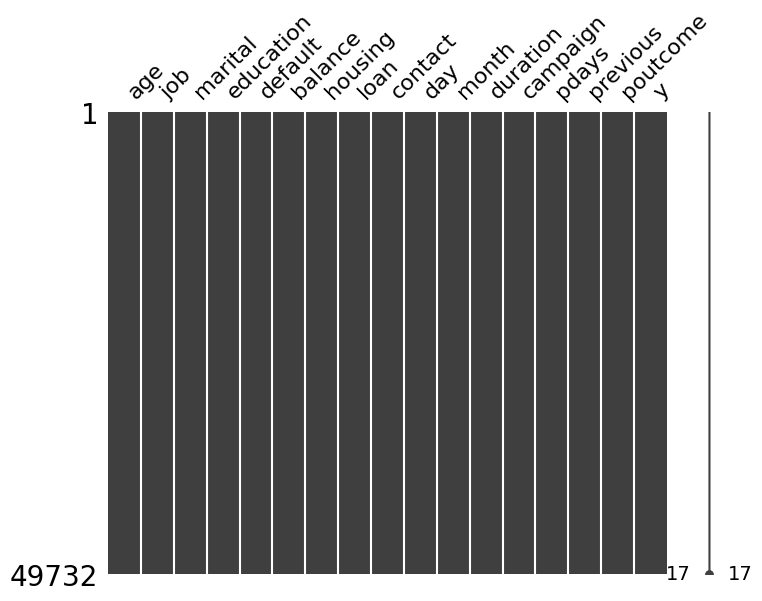

In [ ]:
# Verificando valores faltantes
ms.matrix(df_completo, figsize=(8, 6))

   - **Não temos valores faltantes, como mostro no gráfico**

#### **Resumo estatístico dos atributos com valor numérico**  **negrito**

In [ ]:
# Resumo estatístico dos atributos com valor numérico:
df_completo.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


1. **Idade (age)**:  
   * A média de idade dos clientes é 40,9 anos, chegando ao máximo de 95 anos, mas **75% dos clientes têm até 48 anos**.

2. **Saldo bancário (balance)**:  
   * O saldo médio é de **1.367,76**, mas há uma grande dispersão nos dados, evidenciada pelo desvio padrão de **3.041,60**.  
   * O saldo mínimo é negativo, chegando a **-8.019**, o que indica que alguns clientes podem ter débitos.  
   * O saldo máximo é de **102.127**, mas 75% dos clientes tem até 1431 de saldo, sugerindo uma alta concentração de riqueza em alguns poucos clientes.

3. **Dia do mês da campanha (day)**:  
   * A maioria das interações ocorre em torno do dia **15 ou 16** do mês, com uma mediana de **16**.  
   * O dia mínimo registrado é **1**, e o máximo é **31**, representando o intervalo completo de dias de um mês.

4. **Duração das interações (duration)**:  
   * A mediana é de **180 segundos**, indicando que **50% das interações duram até 3 minutos**.  
   * A duração mínima é **0**, sugerindo que algumas interações podem não ter ocorrido ou terem sido extremamente curtas, enquanto a duração máxima chega a **4.918 segundos** (cerca de **1 hora e 22 minutos**).

5. **Número de campanhas (campaign)**:  
   * A maioria dos clientes foi contatada entre **1 e 3 vezes** (mediana de **2** e terceiro quartil de **3**), mas há casos de clientes contatados até **63 vezes**, o que pode indicar uma estratégia de campanha intensiva.

6. **Dias desde o último contato (pdays)**:  
   * Um valor de **-1** para **75% dos casos** indica que a maioria dos clientes não foi contatada anteriormente.  
   * Para os outros **25%**, a média de dias desde o último contato é **40**, com um valor máximo de **871 dias**, o que sugere uma grande dispersão no tempo de recontato.

7. **Quantidade de contatos anteriores (previous)**:  
   * A mediana e o terceiro quartil indicam que a maioria dos clientes (**75%**) não teve contatos anteriores (valor de **0**).  
   * No entanto, alguns clientes foram contatados várias vezes anteriormente, com um valor máximo de **275 contatos**.

#### **Analise sobre a Distribuição dos Atributos**:

##### **Analise Box Plot dos Atributos**:

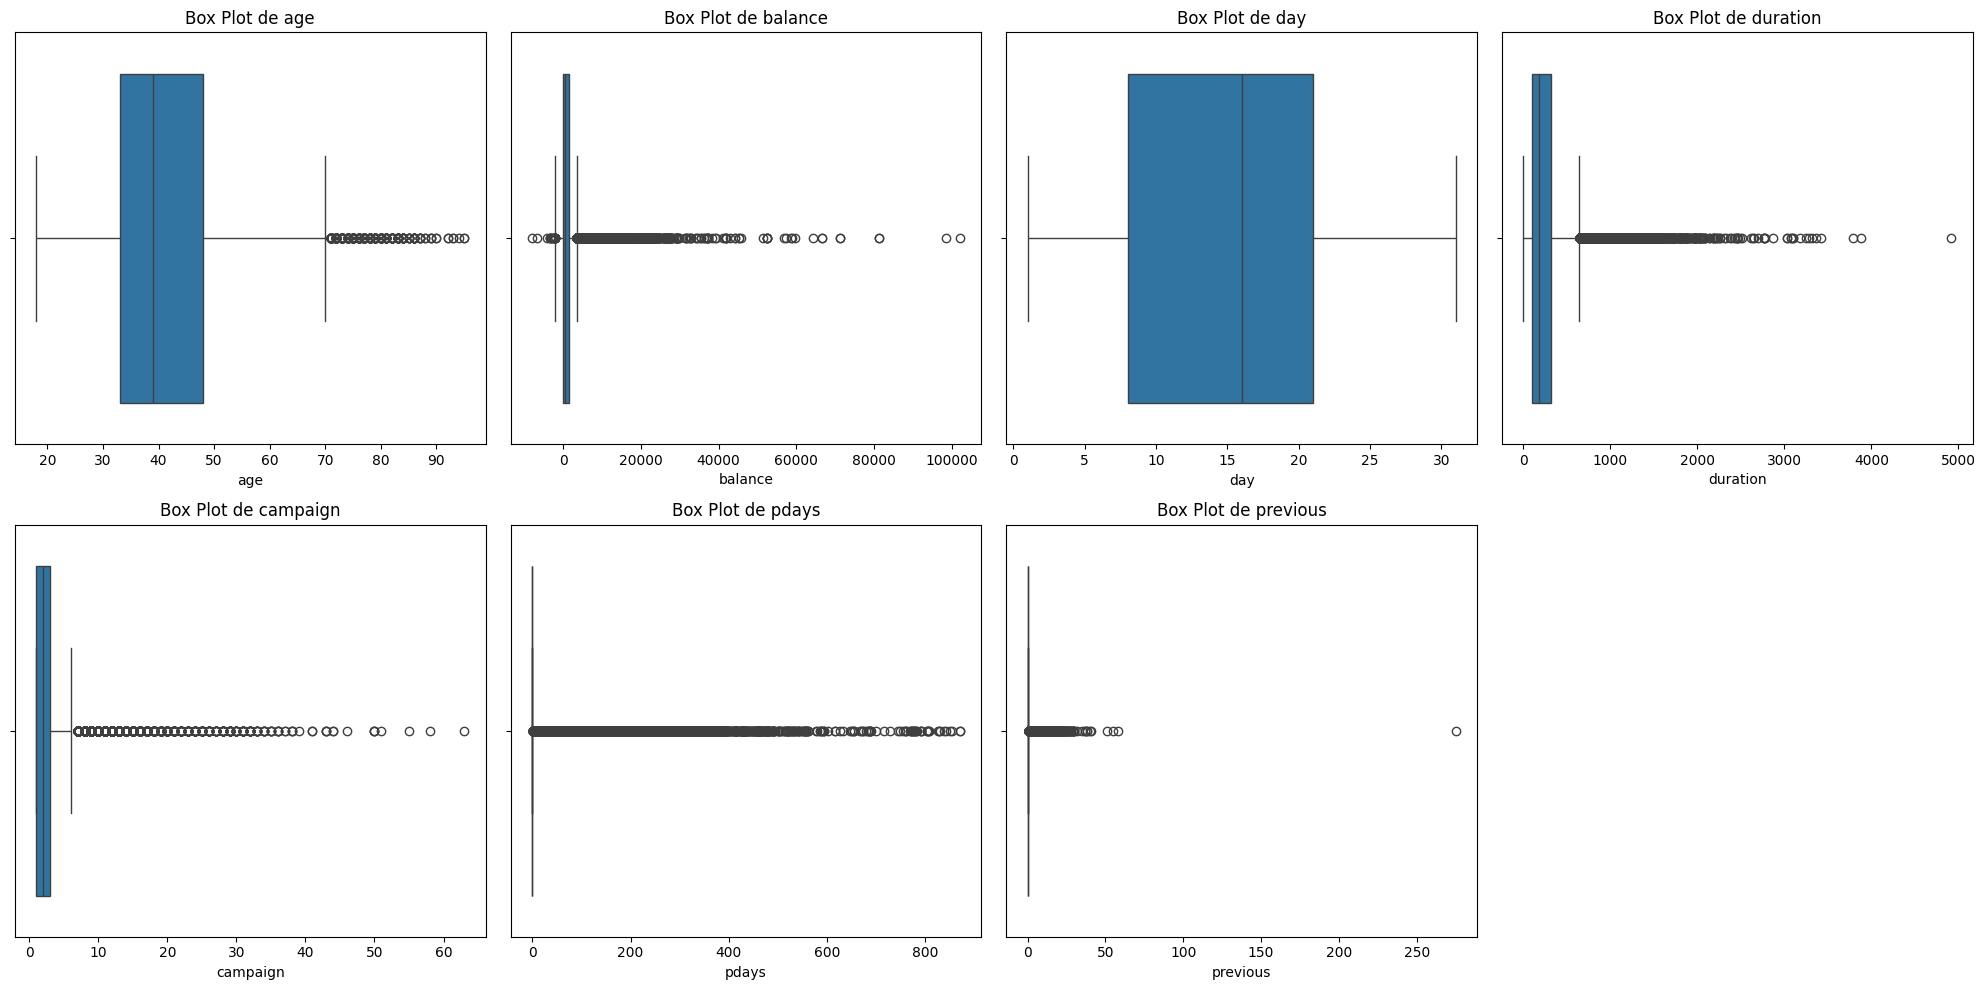

In [ ]:
#Boxplot

# Selecionar os atributos numéricos do DataFrame
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Criar a figura e os eixos para o layout 2x4 (2 linhas e 4 colunas)
num_attributes = len(numerical_columns)
num_rows = (num_attributes + 3) // 4  # Ajusta o número de linhas com base no número de colunas
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, num_rows * 5))

# Achatar o array de eixos se necessário
axes = axes.flatten()

# Criar um boxplot para cada atributo numérico
for i, col in enumerate(numerical_columns):
    sns.boxplot(x=df_completo[col], ax=axes[i])
    axes[i].set_title(f"Box Plot de {col}")

# Remover os eixos não utilizados, se houver
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()

1. **Idade (age)**:
   - A variável `age` está bem distribuída entre aproximadamente 20 e 60 anos, com uma mediana em torno dos 40 anos.
   - Apesar da presença de alguns outliers, com idades superiores a 70 anos, esses valores não parecem exercer uma influência significativa sobre o conjunto de dados.
   - **Ação**: Não será necessário aplicar nenhum tratamento especial, como remoção de outliers ou normalização, visto que a distribuição de `age` é razoavelmente balanceada e interpretável.

2. **Saldo bancário (balance)**:
   - O saldo bancário está majoritariamente concentrado em torno de 0, porém há outliers significativos, com valores que chegam a mais de 100.000, o que pode influenciar a média e variância de maneira distorcida.
   - **Ação**: Para lidar com essa assimetria e comprimir os valores extremamente altos, será aplicada uma **Normalização**, o que tornará a distribuição de `balance` mais simétrica e facilitará a análise.

3. **Dia do mês da campanha (day)**:
   - A distribuição da variável `day`, que vai de 1 a 31, é uniforme, representando os dias do mês em que ocorreram os contatos das campanhas. Não há presença significativa de outliers.
   - **Ação**: Como se trata de uma variável categórica, não será necessário nenhum tratamento adicional, visto que sua distribuição é homogênea.

4. **Duração das interações (duration)**:
   - A maior parte das interações tem uma duração curta, com muitos valores próximos de 0 segundos. No entanto, há outliers que chegam a 5.000 segundos, o equivalente a quase 1 hora e 22 minutos.
   - **Ação**: Será criada uma categorização de `duration` em faixas (curta, média, longa e muito longa) para facilitar a análise.

5. **Número de campanhas (campaign)**:
   - A maioria dos clientes foi contatada entre 1 e 3 vezes, mas há casos de clientes que foram contatados mais de 60 vezes, o que configura outliers extremos.
   - **Ação**: Será aplicada a **remoção de outliers** para os valores mais extremos.

6. **Dias desde o último contato (pdays)**:
   - A maioria dos clientes tem `pdays` com valor -1, indicando que não foram contatados anteriormente. No entanto, para os clientes que foram contatados, há valores que chegam a mais de 800 dias, caracterizando outliers.
   - **Ação**: Será criada uma **flag binária** para indicar se o cliente foi contatado recentemente (1) ou não (0), simplificando a variável e facilitando a análise. A transformação logarítmica pode ser aplicada para os valores restantes, a fim de comprimir os valores mais extremos.

**Considerações Finais**:
- As variáveis que apresentam **outliers**, como `balance`, `duration`, `campaign`, `pdays` e `previous`, passarão por um processo de **remoção de outliers** para garantir que os valores extremos não distorçam as análises e a modelagem.
- A variável `pdays` será simplificada com a criação de uma **flag binária** que indique se o cliente foi contatado recentemente ou não.
- Após esses tratamentos, será aplicada a **normalização** das variáveis numéricas para garantir que todas estejam na mesma escala e possam ser comparadas de maneira adequada durante a modelagem.

##### **Distribuição de Frequência das Classes (Gráfico e Tabela)**

In [ ]:
# Supondo que df seja o seu DataFrame e 'y' seja a coluna de classes
distribuicao_classes = df_completo['y'].value_counts()

# Calcular a porcentagem de cada classe
total_classes = len(df_completo['y'])
porcentagem_classes = (distribuicao_classes / total_classes) * 100

# Exibir a distribuição de frequência das classes
print(distribuicao_classes)
print(porcentagem_classes)

y
no     43922
yes     5810
Name: count, dtype: int64
y
no     88.317381
yes    11.682619
Name: count, dtype: float64


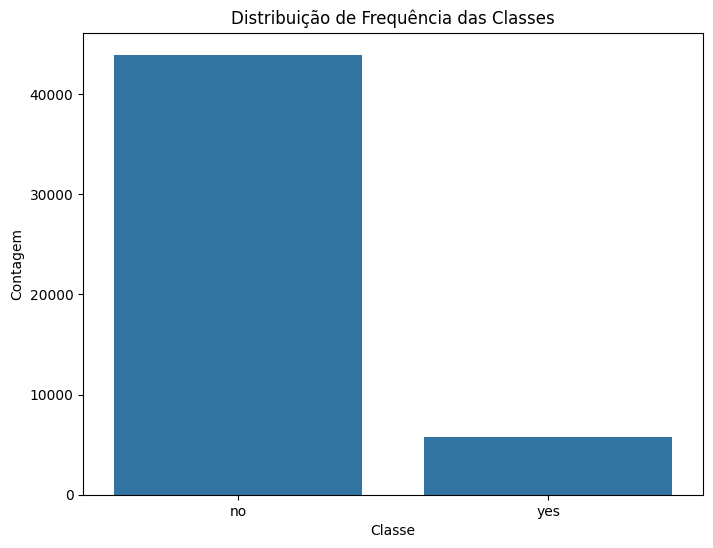

In [ ]:
# Criar um gráfico de barras para a distribuição de classes
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df_completo)
plt.title('Distribuição de Frequência das Classes')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()



1. **Valores Tabulares**:
   - A tabela numérica confirma a observação visual do gráfico:
     - A classe **"no"** contém **43.922 amostras**.
     - A classe **"yes"** contém **5.810 amostras**.
   - Quando observamos a **proporção percentual**:
     - **88,31%** das amostras pertencem à classe "no".
     - Apenas **11,68%** das amostras pertencem à classe "yes".
    
2. **Gráfico de Barras**:
   - O gráfico mostra a **distribuição de frequência** das duas classes (`yes` e `no`) na variável `y`. A classe "no" (clientes que **não** aceitaram a oferta) possui uma quantidade muito maior de amostras em comparação com a classe "yes" (clientes que **aceitaram** a oferta). Isso indica que o conjunto de dados está **desequilibrado**.
   - A classe "no" domina o conjunto de dados, com mais de **40.000 amostras**, enquanto a classe "yes" possui menos de **6.000 amostras**.


   
**Considerações Finais**:
   - A distribuição **desequilibrada** das classes pode impactar a performance dos modelos de machine learning, pois modelos tendem a prever a classe majoritária ("no") com mais frequência, o que pode resultar em baixa acurácia para a classe minoritária ("yes").
   - **Ação**: Sera importante aplicar técnica de balanceamento de dados, como **SMOTE** (Synthetic Minority Over-sampling Technique), para lidar com esse desequilíbrio e melhorar a capacidade preditiva do modelo para a classe minoritária.
   

##### **Heatmap de Correlação entre Atributos Numéricos**

In [ ]:
# Converter a coluna 'Y' para 0 e 1
df_completo['Y_numeric'] = df_completo['y'].map({'no': 0, 'yes': 1})

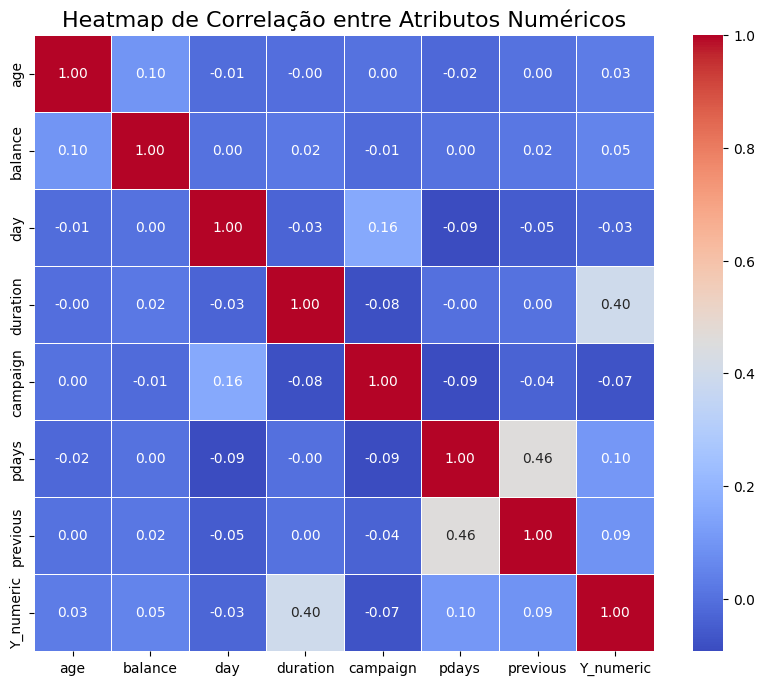

In [ ]:
# colunas numéricas
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous','Y_numeric']

# Calcular a correlação entre as colunas numéricas
correlation_matrix = df_completo[numerical_columns].corr()

# Criar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Adicionar título
plt.title("Heatmap de Correlação entre Atributos Numéricos", fontsize=16)

# Mostrar o gráfico
plt.show()

1. **Correlação entre `duration` e `Y_numeric` (0.40)**
   - A variável `duration` tem uma correlação positiva moderada de 0.40 com `Y_numeric`, indicando que interações mais longas podem aumentar a chance de aceitação do produto.

2. **Correlação entre `previous` e `pdays` (0.46)**
   - Existe uma correlação moderada de 0.46 entre `previous` (contatos anteriores) e `pdays` (dias desde o último contato), sugerindo que clientes frequentemente contatados anteriormente tendem a ter um intervalo maior desde o último contato.

3. **Correlação entre `age`, `balance`, `day`, `campaign`, e `pdays`**
   - Estas variáveis mostram correlações muito baixas entre si, indicando que não há uma relação linear direta significativa que conecte essas dimensões.

4. **Correlação entre `age` e outras variáveis (baixa)**
   - A idade (`age`) não mostra correlações fortes com outras variáveis, o que pode indicar que a idade, por si só, não é um fator crítico nas campanhas observadas.

5. **Correlação entre `pdays` e `Y_numeric` (0.10)**  
   - `pdays` tem uma correlação fraca de 0.10 com `Y_numeric`, sugerindo que o tempo desde o último contato tem um impacto limitado na aceitação do produto.


**Considerações Finais**:
- **Foco na duração das interações**: `duration` é a variável com maior correlação com o resultado, sugerindo que focar em prolongar as interações pode ser uma estratégia eficaz.
- **Segmentação baseada no histórico de interações**: A correlação entre `previous` e `pdays` pode ser utilizada para segmentar clientes em futuras campanhas.
- **Independência das outras variáveis**: As baixas correlações entre a maioria das variáveis indicam que elas podem ter efeitos independentes ou não lineares sobre os resultados.

### **Tratamentos Aplicados**:



1. **Separação dos Dados para Treino e Teste**:
   - Após o pré-processamento, separei os dados em conjuntos de **treino** (80%) e **teste** (20%). Esta divisão foi feita para garantir que o modelo seja avaliado de maneira justa em dados "nunca vistos" e que os resultados possam ser generalizados para novos dados.
2. **Remoção de Outliers**:
   - Removi os outliers com base em um limite de 3 vezes o desvio padrão para eliminar valores extremos que poderiam distorcer a análise. Esse tratamento foi aplicado às variáveis `balance`, `duration`, `campaign` e `pdays` para garantir que dados extremos não influenciem negativamente o modelo.

3. **Criação de Categorias e Flags**:
   - **Duration**: Como a variável `duration` apresentou variações relevantes, foi categorizada em quatro faixas: `curta`, `média`, `longa` e `muito longa`. Isso facilita a interpretação e a modelagem, transformando a variável contínua em intervalos discretos.
   - **Pdays**: Criei uma flag binária para representar se o cliente foi contatado recentemente, com base no valor de `pdays`. Se o cliente foi contatado recentemente, a flag recebe o valor 1, caso contrário, recebe 0.

4. **Conversão de Variáveis Categóricas (One-Hot Encoding)**:
   - Para que o modelo de machine learning possa trabalhar com variáveis categóricas, apliquei **One-Hot Encoding** nas variáveis `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `poutcome` e `duration_category`. Isso cria colunas binárias para cada valor único dessas categorias, possibilitando que o modelo utilize essas informações corretamente.

5. **Normalização**:
   - Após a separação dos dados em treino e teste, foi aplicada a **normalização** usando o **MinMaxScaler** apenas nos dados de treino e, em seguida, o mesmo scaler foi aplicado aos dados de teste. Essa normalização é crucial para garantir que todas as variáveis numéricas, como `balance`esteja na mesma escala, ajustando os valores para o intervalo entre 0 e 1.
   

6. **Balanceamento com SMOTE**:
   - Para lidar com o desequilíbrio entre as classes, apliquei a técnica de **SMOTE** (Synthetic Minority Over-sampling Technique) ao conjunto de treino. O SMOTE cria exemplos sintéticos da classe minoritária para equilibrar a distribuição das classes, permitindo que o modelo tenha mais exemplos dessa classe para aprender. A técnica foi aplicada apenas nos dados de treino (`X_train` e `y_train`), garantindo que o conjunto de teste mantenha a distribuição original das classes.
   - **Por que aplicar SMOTE apenas no treino?**: O SMOTE é aplicado apenas nos dados de treino porque o objetivo é ajudar o modelo a aprender padrões da classe minoritária sem influenciar o conjunto de teste. O conjunto de teste deve refletir a distribuição real dos dados para que a avaliação do modelo seja precisa e imparcial.  


7. **Seleção de Features (Feature Selection)**:
   - A seleção de features foi realizada utilizando Random Forest para identificar as variáveis mais importantes e reduzir a dimensionalidade.
   - **Processo**:
     - Treinei um modelo Random Forest com os dados de treino e teste para calcular a importância de cada feature.
     - As features com maior importância foram selecionadas, limitando o número de variáveis a `num_features` (padrão: 10).

#### 1. **Separação da Base em Treino e Teste**

In [ ]:
df_completo = df_completo.drop(columns=['y'])  # Removendo a coluna 'y' pois ja estamos usando 'Y_numeric'

In [ ]:
# Separando as features e o target (variável Y_numeric)
X = df_completo.drop(columns='Y_numeric')  # Excluindo a coluna 'Y_numeric', que é o target
y = df_completo['Y_numeric']  # Definindo 'Y_numeric' como target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

#### 2. **Tratamento de Outliers**
Os outliers são valores extremos que podem distorcer os resultados da análise e da modelagem.
Para tratá-los, apliquei uma regra de 3 vezes o desvio padrão. Dessa forma, valores que estão
além de 3 desvios da média são considerados outliers e removidos.
Neste caso, removemos outliers das colunas balance, duration, campaign e pdays.

In [ ]:
# Colunas para remover outliers
columns_to_check = ['balance', 'duration', 'campaign', 'pdays']

# Remover outliers
X_train_filtered, y_train_filtered = remove_outliers_df(X_train, y_train, columns_to_check)

# Remover outliers
X_test_filtered, y_test_filtered = remove_outliers_df(X_test, y_test, columns_to_check)

In [ ]:
# Antes tratamento
X_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000
mean,40.947040,1365.341184,15.834259,258.168682,2.768053,40.469323,0.575091
std,10.618058,3033.612982,8.320385,257.669571,3.069883,100.399758,1.904345
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,445.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1425.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,58.000000


In [ ]:
#Após tratamento
X_train_filtered.describe()

,age,balance,day,duration,campaign,pdays,previous
count,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000
mean,40.978902,1088.587093,15.823497,236.612962,2.468092,28.999890,0.504137
std,10.643198,1726.183487,8.357379,191.219155,1.957716,77.372516,1.754275
min,18.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,67.000000,8.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,431.000000,16.000000,178.000000,2.000000,-1.000000,0.000000
75%,48.000000,1355.000000,21.000000,308.000000,3.000000,-1.000000,0.000000
max,95.000000,10465.000000,31.000000,1031.000000,12.000000,345.000000,51.000000


#### 3. **Criação de Categorias e Flags**
Algumas variáveis, como duration e pdays, foram transformadas para facilitar a interpretação do modelo.
Duration foi categorizada em quatro intervalos: curta, média, longa e muito longa duração.
Além disso, uma flag binária foi criada para indicar se o cliente foi contatado recentemente ou não, com base na variável pdays.

In [ ]:
# Aplicando a criação das flags
X_train_transformed = categorize_duration_df(X_train_filtered, 'duration')
X_train_transformed = create_recent_contact_flag_df(X_train_transformed, 'pdays')

X_test_transformed = categorize_duration_df(X_test_filtered, 'duration')
X_test_transformed = create_recent_contact_flag_df(X_test_transformed, 'pdays')

In [ ]:
X_train_transformed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,poutcome,duration_category,recent_contact
29709,36,self-employed,divorced,secondary,no,-38,yes,no,cellular,18,nov,2,0,unknown,média,0
25911,31,technician,divorced,secondary,no,431,yes,yes,cellular,18,aug,2,0,unknown,curta,0
33720,31,technician,single,tertiary,no,1625,no,no,cellular,2,feb,1,0,unknown,média,0
35022,25,student,single,secondary,no,2354,no,no,cellular,5,feb,7,0,unknown,média,0
28692,32,management,married,tertiary,no,62,yes,no,telephone,13,nov,1,0,unknown,curta,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,46,unknown,married,unknown,no,613,no,no,unknown,6,jun,1,0,unknown,curta,0
919,25,blue-collar,married,secondary,no,-76,yes,no,unknown,12,may,3,0,unknown,média,0
38467,26,self-employed,single,tertiary,no,168,no,no,cellular,30,apr,1,0,unknown,longa,0
10742,30,management,single,tertiary,no,3773,yes,no,unknown,27,may,1,0,unknown,curta,0


#### 4. **Conversão de Variáveis Categóricas (One-Hot Encoding)**
As variáveis categóricas precisam ser convertidas em um formato que os modelos de machine learning possam entender.
Para isso, usamos o One-Hot Encoding, que cria colunas binárias (0 ou 1) para cada valor único das variáveis categóricas.

In [ ]:
# Colunas categóricas do DataFrame
categorical_features_names = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'duration_category']

# Aplicando o One-Hot Encoding
X_train_encoded = apply_onehot_encoding_df(X_train_transformed, categorical_features_names)
X_test_encoded = apply_onehot_encoding_df(X_test_transformed, categorical_features_names)

In [ ]:
X_train_transformed.describe()

,age,balance,day,campaign,previous,recent_contact
count,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000
mean,40.978902,1088.587093,15.823497,2.468092,0.504137,0.158108
std,10.643198,1726.183487,8.357379,1.957716,1.754275,0.364847
min,18.000000,-6847.000000,1.000000,1.000000,0.000000,0.000000
25%,33.000000,67.000000,8.000000,1.000000,0.000000,0.000000
50%,39.000000,431.000000,16.000000,2.000000,0.000000,0.000000
75%,48.000000,1355.000000,21.000000,3.000000,0.000000,0.000000
max,95.000000,10465.000000,31.000000,12.000000,51.000000,1.000000


In [ ]:
X_train_encoded.describe()

,age,balance,day,campaign,previous,recent_contact,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,duration_category_longa,duration_category_muito longa,duration_category_média
count,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,...,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000
mean,40.978902,1088.587093,15.823497,2.468092,0.504137,0.158108,0.212686,0.033398,0.027303,0.208411,...,0.297159,0.088969,0.015720,0.011748,0.034915,0.032184,0.841919,0.195256,0.065692,0.504220
std,10.643198,1726.183487,8.357379,1.957716,1.754275,0.364847,0.409213,0.179675,0.162967,0.406178,...,0.457014,0.284702,0.124391,0.107753,0.183566,0.176492,0.364822,0.396403,0.247747,0.499989
min,18.000000,-6847.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,67.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,39.000000,431.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,48.000000,1355.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,95.000000,10465.000000,31.000000,12.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_train_encoded

,age,balance,day,campaign,previous,recent_contact,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,duration_category_longa,duration_category_muito longa,duration_category_média
29709,36,-38,18,2,0,0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
25911,31,431,18,2,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33720,31,1625,2,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
35022,25,2354,5,7,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
28692,32,62,13,1,0,0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,46,613,6,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
919,25,-76,12,3,0,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
38467,26,168,30,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
10742,30,3773,27,1,0,0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_encoded.dtypes

,0
age,int64
balance,int64
day,int64
campaign,int64
previous,int64
recent_contact,int64
job_blue-collar,float64
job_entrepreneur,float64
job_housemaid,float64
job_management,float64


#### 5. **Normalização**
A variável numérica balance possue escalas muito diferentes.
Para garantir que todas as variáveis numéricas estejam na mesma escala, aplicamos a normalização usando o MinMaxScaler.
Isso ajusta os valores para um intervalo entre 0 e 1.

In [ ]:
## Aplicando normalização no Treino e Teste
X_train_scaled, X_test_scaled = apply_minmax_scaler_df(X_train_encoded, X_test_encoded, 'balance')

In [ ]:
X_train_scaled.describe()

,age,balance,day,campaign,previous,recent_contact,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,duration_category_longa,duration_category_muito longa,duration_category_média
count,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,...,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000,36260.000000
mean,40.978902,0.458387,15.823497,2.468092,0.504137,0.158108,0.212686,0.033398,0.027303,0.208411,...,0.297159,0.088969,0.015720,0.011748,0.034915,0.032184,0.841919,0.195256,0.065692,0.504220
std,10.643198,0.099710,8.357379,1.957716,1.754275,0.364847,0.409213,0.179675,0.162967,0.406178,...,0.457014,0.284702,0.124391,0.107753,0.183566,0.176492,0.364822,0.396403,0.247747,0.499989
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.399376,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,39.000000,0.420402,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,48.000000,0.473775,21.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,95.000000,1.000000,31.000000,12.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 6. **Balanceamento**
O dataset original apresentava um desequilíbrio significativo entre as classes, com a classe majoritária sendo muito mais representada do que a minoritária. Esse desequilíbrio pode impactar negativamente a performance do modelo, pois ele pode ter uma tendência a prever mais a classe majoritária. Para corrigir isso, apliquei a técnica **SMOTE (Synthetic Minority Over-sampling Technique)**. O SMOTE gera exemplos sintéticos da classe minoritária com base nos seus vizinhos mais próximos, criando novos pontos de dados e equilibrando a distribuição de classes. Essa técnica ajuda o modelo a aprender de maneira mais eficiente sobre a classe minoritária sem simplesmente duplicar amostras existentes.



In [ ]:
# Aplicando balanceamento no Treino
X_train_balanced, y_train_balanced = apply_smote_to_df(X_train_encoded, y_train_filtered)


Distribuição das classes antes do SMOTE: {0: 32449, 1: 3811}
Distribuição das classes após o SMOTE: {0: 32449, 1: 32449}


#### 7. **feature selection**

In [ ]:
# Após o pré-processamento e balanceamento dos dados:
X_train_selected, X_test_selected = feature_selection_with_rf(X_train_balanced, y_train_balanced, X_test_scaled)

Atributo age: 0.04755307070892652
Atributo balance: 0.05345609341862187
Atributo day: 0.04185947529325349
Atributo campaign: 0.031731556351939444
Atributo previous: 0.011610238093439928
Atributo recent_contact: 0.007763573460365706
Atributo job_blue-collar: 0.01628666709312894
Atributo job_entrepreneur: 0.0023178446004484114
Atributo job_housemaid: 0.002083335988404507
Atributo job_management: 0.011919905063148144
Atributo job_retired: 0.00439425305235196
Atributo job_self-employed: 0.003216028327095973
Atributo job_services: 0.006956817602499466
Atributo job_student: 0.004179527117888359
Atributo job_technician: 0.011168837653948958
Atributo job_unemployed: 0.003015407171299584
Atributo job_unknown: 0.0005825025925264937
Atributo marital_married: 0.019397727826001198
Atributo marital_single: 0.010155630139727591
Atributo education_secondary: 0.019854425178321394
Atributo education_tertiary: 0.01747881810436391
Atributo education_unknown: 0.0032858395314062008
Atributo default_yes: 0.0

In [ ]:
X_train_selected

,duration_category_muito longa,housing_yes,duration_category_longa,poutcome_success,contact_unknown,balance,duration_category_média,age,day,campaign
0,0.000000,1.000000,0.0,0.0,0.000000,0.393311,1.000000,36,18,2
1,0.000000,1.000000,0.0,0.0,0.000000,0.420402,0.000000,31,18,2
2,0.000000,0.000000,0.0,0.0,0.000000,0.489372,1.000000,31,2,1
3,0.000000,0.000000,0.0,0.0,0.000000,0.531481,1.000000,25,5,7
4,0.000000,1.000000,0.0,0.0,0.000000,0.399087,0.000000,32,13,1
...,...,...,...,...,...,...,...,...,...,...
64893,0.000000,0.000000,1.0,0.0,0.000000,0.399472,0.000000,32,8,2
64894,0.000000,0.655638,1.0,0.0,0.655638,0.498407,0.000000,54,5,1
64895,0.254352,0.000000,0.0,1.0,0.000000,0.538639,0.745648,35,9,2
64896,0.000000,1.000000,1.0,0.0,0.098534,0.413825,0.000000,28,6,1


## **Modelagem e treinamento**:

#### **Tipo de Validação**

Para evitar overfitting e assegurar que o modelo tenha um bom desempenho em dados novos, optei por utilizar a validação cruzada.

### **Seleção de Modelos para Classificação**

**Seleção de Modelos para Classificação**

**Objetivo**
Neste trabalho, meu objetivo é construir um modelo de classificação para prever a assinatura de um produto bancário ("yes" ou "no") com base em variáveis demográficas, financeiras e de interação. Para isso, seguirei uma abordagem estruturada envolvendo a seleção e avaliação de modelos adequados.

**Modelos a Serem Testados**
Os seguintes modelos serão testados, considerando suas características e adequação ao problema:

- **Decision Tree**: Um modelo interpretável que utiliza regras simples para separar as classes, adequado como ponto de partida.
- **Random Forest**: Combina várias árvores de decisão para melhorar a robustez e reduzir o risco de overfitting.
- **Gradient Boosting**: Um modelo que otimiza iterativamente árvores de decisão, excelente para problemas complexos.
- **AdaBoost**: Modelo baseado em boosting que atribui pesos maiores a amostras mal classificadas, ajustando iterativamente.
- **Logistic Regression**: Modelo linear simples e interpretável, utilizado como benchmark inicial.
- **LightGBM**: Variante de boosting que utiliza histogramas para acelerar a computação, eficiente para grandes datasets.
- **K-Nearest Neighbors (KNN)**: Modelo baseado na proximidade entre os dados, útil para explorar agrupamentos naturais.
- **CatBoost**: Algoritmo de boosting otimizado para lidar com variáveis categóricas, indicado para problemas de classificação complexos.

**Estratégia de Avaliação**
Para selecionar o melhor modelo, seguirei os passos abaixo:

1. **Validação Cruzada**: Realizarei validação cruzada com 10 divisões (K-Fold) para garantir resultados consistentes e reduzir variabilidade.
2. **Comparação de Modelos**: Testarei os modelos acima, avaliando seus desempenhos em dados balanceados.
3. **Métricas de Avaliação**: Utilizarei as seguintes métricas para comparar os modelos:
   - **Acurácia**: Para medir a proporção de predições corretas.
   - **AUC-ROC**: Avaliará a capacidade de distinguir classes positivas e negativas.
   - **F1-Score**: Indicará o equilíbrio entre precisão e recall.
   - **Matriz de Confusão**: Fornecerá insights detalhados sobre os erros de classificação.
4. **Boxplot de Comparação**: Representarei graficamente as distribuições da acurácia para todos os modelos.
5. **Escolha Final**: O modelo será escolhido com base no equilíbrio entre desempenho, interpretabilidade e viabilidade computacional.

**Resultados Esperados**
Com essa abordagem, espero identificar o modelo que melhor se adapta ao problema, considerando os desafios específicos dos dados e a necessidade de alta performance em classificação.

#### **Validação Cruzada para Comparação de Modelos**

**Atenção esse código é demorado, deixei o Print do resultado da execução abaixo do código**

In [ ]:
# Definindo uma seed global
np.random.seed(7)

# Configuração de validação cruzada
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('LightGBM', LGBMClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CatBoost', CatBoostClassifier(verbose=0)))

# Avaliando um modelo por vez
for name, model in models:
    cv_results = cross_val_score(model, X_train_selected, y_train_balanced, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())  # média e desvio padrão
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

KeyboardInterrupt: 

**Devido ao longo tempo de execução do script, aproximadamente 7 minutos e 30 segundos, apresento abaixo o print do gráfico gerado e os resultados da acurácia da validação cruzada dos modelos.**

Decision Tree: 0.921169 (0.002168)  
Random Forest: 0.940784 (0.002892)  
Gradient Boosting: 0.894897 (0.004296)  
AdaBoost: 0.884758 (0.004398)  
Logistic Regression: 0.812737 (0.004297)  
LightGBM: 0.908965 (0.004520)  
KNN: 0.874665 (0.003917)  
CatBoost: 0.918657 (0.003940)  

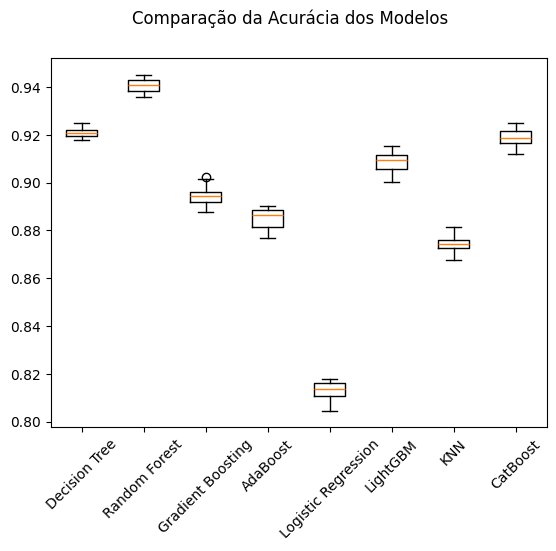

#### **Avaliação dos Modelos no Conjunto de Teste**

**Atenção esse código é demorado, deixei o Print do resultado da execução abaixo do código**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32449, number of negative: 32449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 64898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


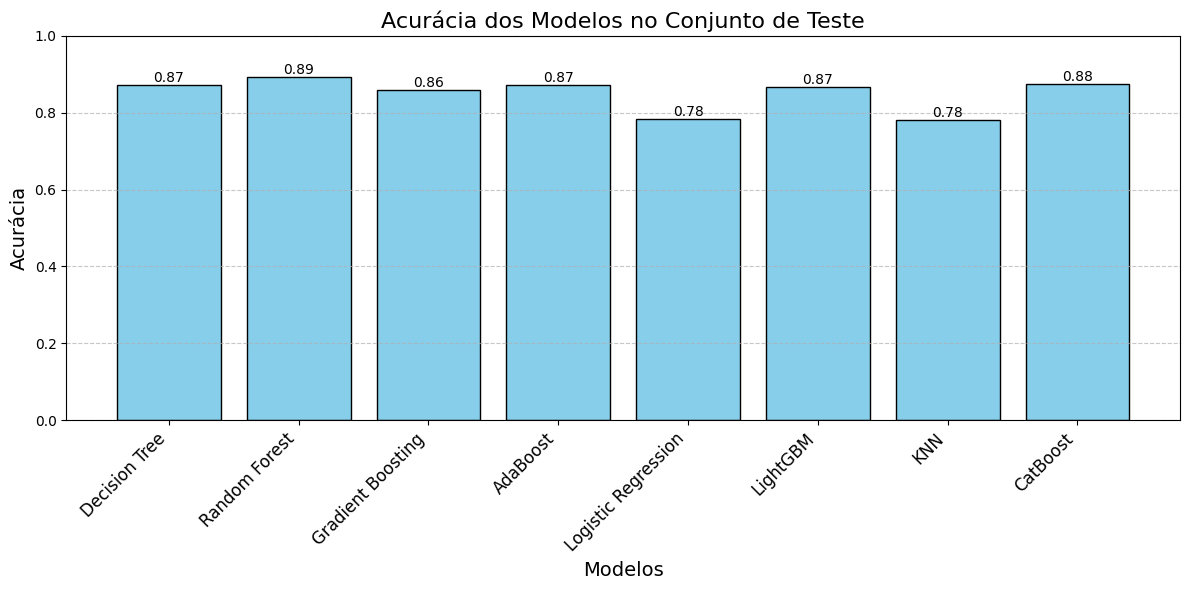

In [ ]:
# Armazenando os resultados
test_results = []
test_names = []

for name, model in models:
    model.fit(X_train_selected, y_train_balanced)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test_filtered, y_pred)
    test_results.append(acc)
    test_names.append(name)

# Gráfico de barras dos resultados no conjunto de teste
plt.figure(figsize=(12, 6))
bars = plt.bar(test_names, test_results, color='skyblue', edgecolor='black')
plt.title("Acurácia dos Modelos no Conjunto de Teste", fontsize=16)
plt.ylabel("Acurácia", fontsize=14)
plt.xlabel("Modelos", fontsize=14)
plt.ylim(0, 1)

# Ajustando o espaçamento do eixo x
plt.xticks(rotation=45, fontsize=12, ha='right')

# Adicionando rótulos de dados acima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

**Devido ao longo tempo de execução do script, apresento abaixo o print do gráfico gerado e os resultados da acurácia dos modelos no conjunto de teste**

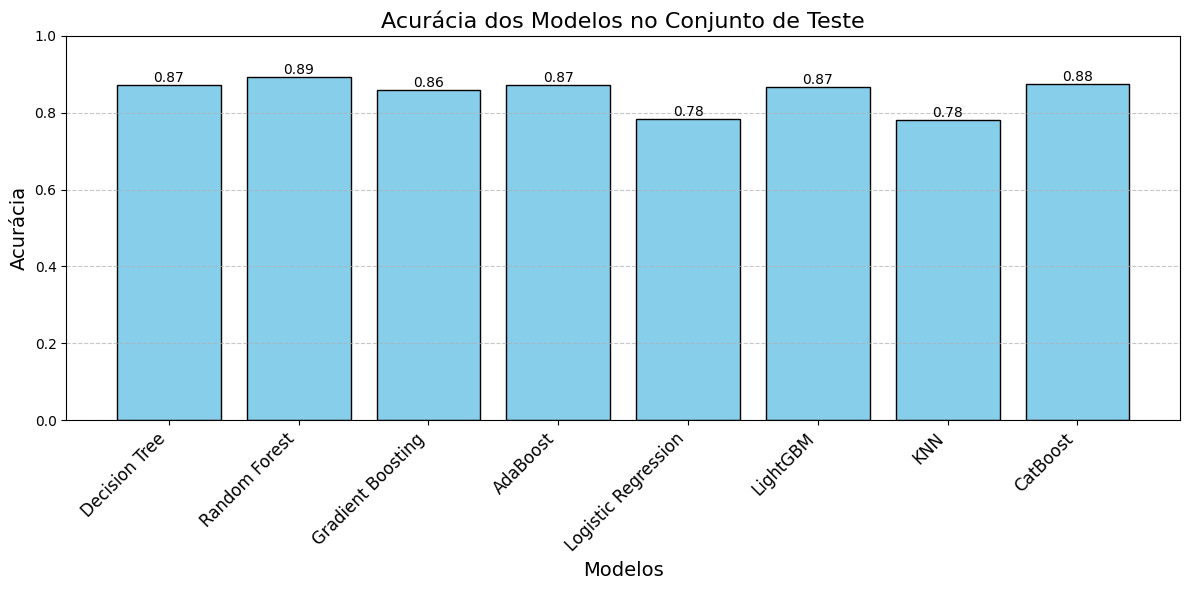

### **Testando modelos no conjunto de teste, mas ajustando seus hiperparâmetros**

#### **Decision Tree**





 **Justificativa para os Hiperparâmetros**

1. **`class_weight='balanced'`**:
   - Utilizado para corrigir o desbalanceamento entre as classes, ajustando automaticamente os pesos das classes inversamente proporcionais à sua frequência. Isso ajuda a evitar viés para a classe majoritária.

2. **`max_depth=10`**:
   - Limitar a profundidade controla o crescimento da árvore e previne overfitting. O valor de 10 foi escolhido como um ponto médio para garantir generalização, com base na complexidade esperada do conjunto de dados.

3. **`min_samples_split=20`**:
   - Define o número mínimo de amostras para dividir um nó. Um valor maior evita divisões em subconjuntos muito pequenos, reduzindo a variância e melhorando a robustez.

4. **`min_samples_leaf=10`**:
   - Determina o número mínimo de amostras que uma folha deve conter. Isso reduz a probabilidade de criar folhas que representem ruídos nos dados.

5. **`criterion='gini'`**:
   - O índice de Gini é mais rápido computacionalmente do que a entropia e, em muitos casos, apresenta resultados semelhantes. Ele mede a impureza dos nós e é mais eficiente para grandes conjuntos de dados.

6. **`splitter='best'`**:
   - Garante que o melhor divisor seja usado para cada nó, maximizando o ganho de informação em cada divisão.

7. **`random_state=42`**:
   - Assegura que os resultados sejam reprodutíveis, o que é crítico para experimentos consistentes.

In [ ]:
# Ajustando os hiperparâmetros do modelo
cart_model = DecisionTreeClassifier(
    class_weight='balanced',  # Trata classes desbalanceadas ajustando os pesos proporcionalmente
    max_depth=10,  # Reduz a complexidade para evitar overfitting, garantindo maior generalização
    min_samples_split=20,  # Impede divisões prematuras em conjuntos pequenos
    min_samples_leaf=10,  # Garante que folhas não sejam criadas com poucas amostras, reduzindo variância
    criterion='gini',  # É mais eficiente computacionalmente e normalmente comparável à entropia em desempenho
    splitter='best',  # Usa o melhor divisor para maximizar o ganho de informação
    random_state=42  # Garante reprodutibilidade nos resultados
)

# Treinando o modelo
cart_model.fit(X_train_selected, y_train_balanced)
y_pred_cart = cart_model.predict(X_test_selected)

# Avaliação no conjunto de teste
acc_cart = accuracy_score(y_test_filtered, y_pred_cart)
print(f"Acurácia da Árvore de Decisão com regularização no conjunto de teste: {acc_cart}")
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred_cart))
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred_cart))

Acurácia da Árvore de Decisão com regularização no conjunto de teste: 0.8363656411952807
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      8092
           1       0.36      0.68      0.47       977

    accuracy                           0.84      9069
   macro avg       0.66      0.77      0.69      9069
weighted avg       0.89      0.84      0.86      9069

Matriz de confusão:
[[6920 1172]
 [ 312  665]]


#### **Random Forest**

**Justificativa para os Hiperparâmetros**

1. **`n_estimators=200`**:
   - O número de árvores foi aumentado para 200, fornecendo maior robustez ao modelo e reduzindo o impacto de amostras ruidosas. Mais árvores geralmente melhoram o desempenho, mas é necessário monitorar o tempo de treinamento.

2. **`max_depth=15`**:
   - Uma maior profundidade permite ao modelo capturar padrões mais complexos nos dados. No entanto, é importante monitorar o overfitting em conjuntos de validação.

3. **`min_samples_split=10`**:
   - Define que um nó deve ter pelo menos 10 amostras para ser dividido, ajudando a prevenir divisões em subconjuntos muito pequenos e reduzindo a variância do modelo.

4. **`min_samples_leaf=5`**:
   - Garante que cada folha tenha pelo menos 5 amostras, o que ajuda a evitar folhas com poucas amostras, tornando o modelo mais robusto contra ruído.

5. **`max_features='sqrt'`**:
   - Limita o número de recursos considerados para a divisão em cada nó. Usar a raiz quadrada do número total de recursos é uma prática comum em Random Forest, equilibrando performance e diversidade entre as árvores.

6. **`class_weight='balanced'`**:
   - Ajusta os pesos das classes para compensar o desbalanceamento no conjunto de dados, melhorando a capacidade do modelo de prever corretamente as classes minoritárias.

7. **`random_state=42`**:
   - Define uma semente fixa para garantir a reprodutibilidade dos resultados.

In [ ]:
# Ajustando os hiperparâmetros do modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,            # Testando mais árvores para maior robustez
    max_depth=15,                # Maior profundidade para capturar mais padrões complexos
    min_samples_split=10,        # Mais amostras para dividir um nó
    min_samples_leaf=5,          # Número mínimo de amostras em uma folha
    max_features='sqrt',         # Seleção de recursos baseada na raiz quadrada dos recursos totais
    class_weight='balanced',     # Compensar classes desbalanceadas
    random_state=42              # Garantir reprodutibilidade
)

# Treinando o modelo
rf_model.fit(X_train_selected, y_train_balanced)
y_pred = rf_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

Acurácia no conjunto de teste: 0.8687
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      8092
           1       0.43      0.62      0.51       977

    accuracy                           0.87      9069
   macro avg       0.69      0.76      0.71      9069
weighted avg       0.90      0.87      0.88      9069

Matriz de confusão:
[[7269  823]
 [ 368  609]]


#### **Gradient Boosting**

**Justificativa para os Hiperparâmetros**

1. **`n_estimators=200`**:
   - Aumentar o número de árvores permite que o modelo capture mais padrões nos dados. Embora isso aumente o tempo de treinamento, pode melhorar a robustez do modelo.

2. **`max_depth=7`**:
   - Maior profundidade permite capturar padrões complexos nos dados, porém com maior risco de overfitting. O valor foi escolhido com base em um equilíbrio entre complexidade e generalização.

3. **`learning_rate=0.05`**:
   - Uma taxa de aprendizado menor permite que o modelo faça ajustes mais graduais em cada iteração, reduzindo o risco de pular mínimos locais importantes. Esse ajuste melhora a capacidade de generalização.

4. **`colsample_bytree=0.8`**:
   - Usar 80% dos recursos para cada árvore aumenta a diversidade entre as árvores, reduzindo o risco de overfitting.

5. **`subsample=0.8`**:
   - Usar apenas 80% das amostras para treinar cada árvore também melhora a robustez do modelo, evitando overfitting.

6. **`scale_pos_weight=len(y_train) / sum(y_train == 1)`**:
   - Corrige o desbalanceamento das classes ajustando o peso das amostras positivas proporcionalmente à sua frequência no conjunto de dados.

7. **`gamma=1`**:
   - Introduz regularização nos ganhos necessários para dividir um nó, reduzindo divisões insignificantes e ajudando a simplificar o modelo.

8. **`reg_alpha=0.1`**:
   - Regularização L1 penaliza a complexidade do modelo, ajudando a selecionar apenas as características mais relevantes.

9. **`reg_lambda=1.0`**:
   - Regularização L2 reduz a magnitude dos coeficientes, ajudando a evitar overfitting.

10. **`random_state=42`**:
    - Garante que os resultados sejam reprodutíveis, importante para análises consistentes.

In [ ]:
# Ajustando os hiperparâmetros do modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,              # Aumentando o número de árvores para maior robustez
    max_depth=7,                   # Maior profundidade para capturar mais padrões
    learning_rate=0.05,            # Taxa de aprendizado reduzida para melhor ajuste
    colsample_bytree=0.8,          # Fracção de recursos utilizados por árvore
    subsample=0.8,                 # Fracção de amostras utilizadas para treinamento
    scale_pos_weight=len(y_train) / sum(y_train == 1),  # Balancear classes desbalanceadas
    gamma=1,                       # Regularização para evitar divisões insignificantes
    reg_alpha=0.1,                 # Regularização L1 para reduzir complexidade do modelo
    reg_lambda=1.0,                # Regularização L2 para evitar overfitting
    random_state=42                # Garantir reprodutibilidade
)

# Treinando o modelo
xgb_model.fit(X_train_selected, y_train_balanced)
y_pred = xgb_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

Acurácia no conjunto de teste: 0.7315
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      8092
           1       0.27      0.87      0.41       977

    accuracy                           0.73      9069
   macro avg       0.62      0.79      0.62      9069
weighted avg       0.90      0.73      0.78      9069

Matriz de confusão:
[[5783 2309]
 [ 126  851]]


#### **AdaBoost**

**Justificativa para os Hiperparâmetros**

1. **`estimator=DecisionTreeClassifier(max_depth=1)`**:
   - Define o classificador base como uma árvore de decisão com profundidade máxima de 1 (stump), o que é recomendado para o AdaBoost. Isso permite ao modelo combinar muitos classificadores fracos para criar um modelo forte.

2. **`n_estimators=50`**:
   - Aumenta o número de classificadores fracos para melhorar a capacidade do modelo de capturar padrões complexos nos dados. Um valor de 50 é um bom ponto de partida para equilibrar desempenho e custo computacional.

3. **`learning_rate=0.1`**:
   - Reduz a taxa de aprendizado, permitindo que os classificadores contribuam de forma mais equilibrada para a combinação final. Taxas menores ajudam a evitar ajustes excessivamente agressivos.

4. **`random_state=42`**:
   - Garante a reprodutibilidade dos resultados, importante para manter a consistência entre execuções.

In [ ]:
# Ajustando os hiperparâmetros do modelo AdaBoost
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),  # Classificador fraco: stump
    n_estimators=50,               # Número de classificadores fracos
    learning_rate=0.1,              # Reduzindo a taxa de aprendizado para ajustes mais graduais
    random_state=42                 # Garante reprodutibilidade
)

# Treinando o modelo
ada_model.fit(X_train_selected, y_train_balanced)
y_pred = ada_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

Acurácia no conjunto de teste: 0.8657
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      8092
           1       0.41      0.58      0.48       977

    accuracy                           0.87      9069
   macro avg       0.68      0.74      0.70      9069
weighted avg       0.89      0.87      0.88      9069

Matriz de confusão:
[[7280  812]
 [ 406  571]]


#### **Logistic Regression com Regularização**

**Justificativa para os Hiperparâmetros**

1. **`penalty='l2'`**:
   - A regularização L2 (ridge) é escolhida para evitar overfitting ao penalizar coeficientes grandes, mantendo a estabilidade do modelo.

2. **`solver='liblinear'`**:
   - O solver `liblinear` é eficiente para conjuntos de dados pequenos ou médios e é compatível com a regularização L2.

3. **`C=1.0`**:
   - Esse parâmetro controla a força da regularização. Um valor de 1.0 é um bom ponto de partida, representando regularização moderada. Valores menores aumentam a regularização (maior penalidade), enquanto valores maiores a reduzem.

4. **`class_weight='balanced'`**:
   - Corrige o desbalanceamento de classes ajustando automaticamente os pesos das amostras para refletir sua frequência no conjunto de dados.

5. **`max_iter=200`**:
   - O número máximo de iterações foi aumentado para garantir a convergência do algoritmo, especialmente em conjuntos de dados com muitas variáveis ou classes desbalanceadas.

6. **`random_state=42`**:
   - Garante a reprodutibilidade dos resultados, importante para análises consistentes.

In [ ]:
# Ajustando os hiperparâmetros do modelo de Regressão Logística
lr_model = LogisticRegression(
    penalty='l2',                  # Regularização L2 para evitar overfitting
    solver='liblinear',            # Solver eficiente para conjuntos de dados pequenos ou médios
    C=1.0,                         # Controle da força de regularização
    class_weight='balanced',       # Balancear classes
    max_iter=200,                  # Aumentando o número máximo de iterações
    random_state=42                # Garantir reprodutibilidade
)

# Treinando o modelo
lr_model.fit(X_train_selected, y_train_balanced)
y_pred = lr_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

Acurácia no conjunto de teste: 0.7873
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      8092
           1       0.31      0.77      0.44       977

    accuracy                           0.79      9069
   macro avg       0.64      0.78      0.65      9069
weighted avg       0.90      0.79      0.82      9069

Matriz de confusão:
[[6387 1705]
 [ 224  753]]


#### **LightGBM**

**Justificativa para os Hiperparâmetros**

1. **`n_estimators=200`**:
   - O número de árvores foi aumentado para melhorar a capacidade do modelo de capturar padrões complexos nos dados. Mais árvores geralmente ajudam a reduzir o viés, mas é necessário monitorar o tempo de treinamento.

2. **`max_depth=10`**:
   - Uma profundidade maior permite capturar mais padrões nos dados. Isso pode aumentar o risco de overfitting, mas é compensado por outros parâmetros de regularização, como `subsample` e `colsample_bytree`.

3. **`learning_rate=0.05`**:
   - Reduz a taxa de aprendizado, permitindo ajustes mais graduais durante o treinamento. Isso melhora a capacidade de generalização do modelo.

4. **`num_leaves=50`**:
   - Define o número máximo de folhas por árvore. Esse valor padrão é um bom equilíbrio entre complexidade e desempenho.

5. **`class_weight='balanced'`**:
   - Compensa automaticamente o desbalanceamento de classes ajustando os pesos para refletir sua frequência no conjunto de treinamento.

6. **`subsample=0.8`**:
   - Usa 80% das amostras para treinar cada árvore, reduzindo o risco de overfitting ao introduzir variabilidade no treinamento.

7. **`colsample_bytree=0.8`**:
   - Usa 80% dos recursos em cada árvore para melhorar a diversidade entre as árvores e reduzir o risco de overfitting.

8. **`random_state=42`**:
   - Garante a reprodutibilidade dos resultados, importante para análises consistentes.

In [ ]:
# Ajustando os hiperparâmetros do modelo LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=200,              # Aumentando o número de árvores para maior robustez
    max_depth=10,                  # Profundidade maior para capturar mais padrões
    learning_rate=0.05,            # Taxa de aprendizado reduzida para melhor ajuste
    num_leaves=50,                 # Número máximo de folhas
    class_weight='balanced',       # Compensar classes desbalanceadas
    subsample=0.8,                 # Subamostragem para evitar overfitting
    colsample_bytree=0.8,          # Proporção de recursos usados em cada árvore
    random_state=42                # Garante reprodutibilidade
)

# Treinando o modelo
lgbm_model.fit(X_train_selected, y_train_balanced)
y_pred = lgbm_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32449, number of negative: 32449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 64898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Acurácia no conjunto de teste: 0.8717
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      8092
           1       0.44      0.64      0.52       977

    accuracy                           0.87      9069
   macro avg       0.69      0.77      0.72      9069
weighted avg       0.90      0.87      0.88      9069

Matriz de confusão:
[[72

#### **K-Nearest Neighbors**

**Justificativa para os Hiperparâmetros**

1. **`n_neighbors=5`**:
   - O número de vizinhos foi definido como 5, que é um valor padrão e comumente utilizado. Este valor equilibra o impacto de outliers (menor número de vizinhos) e a suavidade da decisão (maior número de vizinhos). Testes adicionais podem identificar o número ótimo.

2. **`weights='distance'`**:
   - Usa o peso inverso da distância, o que permite que os vizinhos mais próximos tenham maior influência na predição. Isso é útil em conjuntos de dados onde a densidade dos pontos varia.

3. **`metric='manhattan'` e `p=2`**:
    - A métrica Minkowski com `p=2` corresponde à distância Euclidiana, que é amplamente utilizada para medir a similaridade em dados numéricos. Esta é uma escolha padrão para muitos problemas de classificação.

In [ ]:
# Ajustando os hiperparâmetros do modelo KNN
knn_model = KNeighborsClassifier(
    n_neighbors=9,             # Número de vizinhos
    weights='distance',        # Votos ponderados pela distância
    metric='manhattan',        # Métrica de distância
    p=2                        # Distância Euclidiana
)

# Treinando o modelo
knn_model.fit(X_train_selected, y_train_balanced)
y_pred = knn_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

Acurácia no conjunto de teste: 0.8507
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      8092
           1       0.37      0.57      0.45       977

    accuracy                           0.85      9069
   macro avg       0.66      0.73      0.68      9069
weighted avg       0.88      0.85      0.86      9069

Matriz de confusão:
[[7157  935]
 [ 419  558]]


#### **CatBoost**

**Justificativa para os Hiperparâmetros**

1. **`iterations=200`**:
   - O número de iterações foi aumentado para 200 para permitir mais ciclos de ajuste e capturar melhor os padrões nos dados. Esse valor oferece maior capacidade de modelagem sem comprometer muito o tempo de treinamento.

2. **`depth=10`**:
   - Aumentar a profundidade permite que o modelo capture padrões mais complexos nos dados. Uma profundidade de 10 é um equilíbrio entre expressividade e risco de overfitting.

3. **`learning_rate=0.1`**:
   - A taxa de aprendizado padrão de 0.1 é uma escolha inicial segura para modelos robustos como o CatBoost. Valores menores podem ser testados para ajustes mais graduais.

4. **`class_weights=[1, len(y_train_balanced) / sum(y_train_balanced == 1)]`**:
   - Ajusta os pesos das classes para corrigir o desbalanceamento no conjunto de dados. A classe minoritária recebe um peso maior, proporcional à sua frequência relativa.

5. **`l2_leaf_reg=3`**:
   - A regularização L2 padrão ajuda a evitar overfitting penalizando valores extremos dos pesos nas folhas. Este valor é recomendado como ponto de partida.

6. **`random_seed=42`**:
   - Garante a reprodutibilidade dos resultados, essencial para comparações consistentes entre execuções.

7. **`verbose=0`**:
   - Desativa os logs durante o treinamento para manter a saída do código limpa, especialmente em análises interativas como notebooks.

In [ ]:
# Ajustando os hiperparâmetros do modelo CatBoost
cat_model = CatBoostClassifier(
    iterations=200,               # Aumentando o número de iterações para melhor ajuste
    depth=10,                      # Maior profundidade para capturar mais padrões
    learning_rate=0.1,            # Taxa de aprendizado padrão
    class_weights=[1, len(y_train_balanced) / sum(y_train_balanced == 1)],  # Balancear classes
    l2_leaf_reg=3,                # Regularização L2 padrão para evitar overfitting
    random_seed=42,               # Garantir reprodutibilidade
    verbose=0                     # Desativar logs para maior clareza
)

# Treinando o modelo
cat_model.fit(X_train_selected, y_train_balanced, verbose=0)
y_pred = cat_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred))

Acurácia no conjunto de teste: 0.8507
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8092
           1       0.39      0.71      0.50       977

    accuracy                           0.85      9069
   macro avg       0.68      0.79      0.71      9069
weighted avg       0.90      0.85      0.87      9069

Matriz de confusão:
[[7026 1066]
 [ 288  689]]


#### **Comparação de Modelos de Classificação**


**Resumo dos Resultados**

| Modelo                  | Acurácia  | Precisão (Classe 1) | Recall (Classe 1) | F1-Score (Classe 1) |
|-------------------------|-----------|----------------------|--------------------|---------------------|
| Decision Tree           | 0.8364    | 0.36                 | 0.68               | 0.47                |
| Random Forest           | 0.8687    | 0.43                 | 0.62               | 0.51                |
| Gradient Boosting       | 0.7315    | 0.27                 | 0.87               | 0.41                |
| AdaBoost                | 0.8657    | 0.41                 | 0.58               | 0.48                |
| Logistic Regression     | 0.7873    | 0.31                 | 0.77               | 0.44                |
| LightGBM                | 0.8717    | 0.44                 | 0.64               | 0.52                |
| K-Nearest Neighbors     | 0.8507    | 0.37                 | 0.57               | 0.45                |
| CatBoost                | 0.8507    | 0.39                 | 0.71               | 0.50                |

---

**Análise e Discussão**

1. **Decision Tree**:
   - A **acurácia de 83,64%** reflete um desempenho razoável, mas com **precisão baixa (36%)** para a classe 1. O **recall (68%)** é moderado, indicando que o modelo consegue identificar uma quantidade razoável de exemplos da classe minoritária.

2. **Random Forest**:
   - Com **acurácia de 86,87%**, este modelo é robusto. O **F1-Score (0,51)** e o **recall (62%)** da classe 1 indicam bom equilíbrio entre as métricas.

3. **Gradient Boosting**:
   - Obteve **acurácia de 73,15%** e um recall elevado (87%) para a classe 1, mas a **precisão baixa (27%)** gera muitos falsos positivos. Este modelo é mais adequado quando maximizar o recall é prioridade.

4. **AdaBoost**:
   - Com **acurácia de 86,57%** e **F1-Score de 0,48** para a classe 1, o modelo tem desempenho consistente, mas com recall (58%) menor em comparação com outros ensembles como Random Forest e LightGBM.

5. **Logistic Regression**:
   - Modelo simples com **acurácia de 78,73%**. Apresenta **recall elevado (77%)** para a classe 1, mas baixa precisão (31%), sendo mais útil em cenários onde recall é mais importante.

6. **LightGBM**:
   - Obteve o **melhor desempenho geral**, com **acurácia de 87,17%** e **F1-Score de 0,52** para a classe 1. O equilíbrio entre precisão (44%) e recall (64%) indica um modelo consistente e bem ajustado.

7. **K-Nearest Neighbors**:
   - Com **acurácia de 85,07%**, este modelo apresenta desempenho inferior ao Random Forest e LightGBM. O **F1-Score (0,45)** e recall (57%) da classe 1 são moderados.

8. **CatBoost**:
   - O **recall elevado (71%)** e o **F1-Score (0,50)** indicam que o modelo consegue capturar bem a classe minoritária. A **acurácia de 85,07%** é comparável à do KNN, mas o desempenho para a classe 1 é mais consistente.

---

**Conclusão**

Após avaliar os modelos:

- **LightGBM** foi escolhido como o melhor modelo devido ao **melhor equilíbrio geral entre precisão, recall e F1-Score da classe minoritária (0,52)**, além de apresentar a maior acurácia (87,17%).
- **Random Forest** é uma alternativa confiável, especialmente pela robustez e desempenho equilibrado, com **F1-Score de 0,51**.
- Se o objetivo for maximizar o recall da classe minoritária, **CatBoost (71%)** ou **Gradient Boosting (87%)** podem ser mais indicados.

O **LightGBM** será utilizado como modelo final devido à sua consistência e bom desempenho global em todas as métricas.

### **Método Avançado Ensembles**

#### **Ensemble com VotingClassifier**

**Justificativa para o Ensemble com VotingClassifier**

1. **Modelos Selecionados**:
   - Os modelos escolhidos (**LightGBM, Random Forest e CatBoost**) foram os três melhores em desempenho individual com base nas métricas de avaliação (acurácia, precisão, recall e F1-Score).
   - Cada modelo tem características complementares:
     - **LightGBM**: Excelente equilíbrio geral entre precisão e recall, rápido e eficiente para grandes conjuntos de dados.
     - **Random Forest**: Robusto e confiável, oferece boa generalização e lida bem com desbalanceamento.
     - **CatBoost**: Forte em lidar com dados categóricos e desbalanceamento, com recall elevado para a classe minoritária.

2. **Estratégia de Votação**:
   - O ensemble usa a estratégia de votação "soft", que combina as probabilidades preditas por cada modelo. Isso permite uma abordagem mais equilibrada, considerando as confiabilidades relativas de cada modelo.

3. **Hiperparâmetros Ajustados**:
   - **LightGBM**:
     - **`n_estimators=200`**: Maior número de árvores para maior robustez.
     - **`max_depth=10`**: Profundidade ajustada para capturar mais padrões sem overfitting.
     - **`learning_rate=0.05`**: Taxa de aprendizado menor para ajustes mais finos.
     - **`colsample_bytree=0.8, subsample=0.8`**: Proporções ajustadas para evitar overfitting.
   - **Random Forest**:
     - **`n_estimators=200`**: Maior número de árvores para robustez.
     - **`max_depth=10`**: Controla o crescimento das árvores para evitar overfitting.
     - **`min_samples_split=10, min_samples_leaf=5`**: Reduz o impacto de divisões em subconjuntos pequenos.
     - **`class_weight='balanced'`**: Compensa o desbalanceamento das classes.
   - **CatBoost**:
     - **`iterations=200`**: Aumenta o número de ciclos de boosting para melhor ajuste.
     - **`depth=8`**: Captura padrões complexos sem overfitting.
     - **`learning_rate=0.1`**: Taxa de aprendizado moderada para boa generalização.
     - **`class_weights`**: Ajusta os pesos para tratar o desbalanceamento de classes.

4. **Benefícios do Ensemble**:
   - O **VotingClassifier** combina a força de cada modelo individual, reduzindo o impacto de suas limitações específicas.
   - A estratégia "soft" permite maior flexibilidade e melhora o desempenho global, especialmente em problemas com classes desbalanceadas.

In [ ]:
# Instanciando os modelos com ajustes de hiperparâmetros
lightgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

random_forest_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

catboost_model = CatBoostClassifier(
    iterations=200,
    depth=8,
    learning_rate=0.1,
    class_weights=[1, len(y_train_balanced) / sum(y_train_balanced == 1)],
    random_seed=42,
    verbose=0
)

# Criando o ensemble com VotingClassifier
voting_model = VotingClassifier(
    estimators=[
        ('lightgbm', lightgbm_model),
        ('random_forest', random_forest_model),
        ('catboost', catboost_model)
    ],
    voting='soft'  # Usa as probabilidades previstas para combinar os resultados
)

# Treinando o ensemble
voting_model.fit(X_train_selected, y_train_balanced)

# Fazendo predições
y_pred_voting = voting_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred_voting)
print(f"Acurácia do ensemble no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test_filtered, y_pred_voting))

# Matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test_filtered, y_pred_voting))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32449, number of negative: 32449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 64898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Acurácia do ensemble no conjunto de teste: 0.8569
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      8092
           1       0.40      0.68      0.51       977

    accuracy                           0.86      9069
   macro avg       0.68      0.78      0.71      9069
weighted avg       0.90      0.86      0.87      9069

Matriz de co

#### **Conclusão**


Após a avaliação dos modelos, o ensemble **VotingClassifier**, composto pelos modelos **LightGBM**, **Random Forest** e **CatBoost**, apresentou uma performance superior em termos de equilíbrio entre as métricas de precisão, recall e F1-Score para a classe minoritária (classe 1). Embora o modelo **LightGBM** tenha sido inicialmente selecionado devido ao seu excelente desempenho individual, a combinação de modelos no ensemble permitiu obter resultados mais consistentes.

---

**Comparação entre LightGBM e VotingClassifier**

| Métrica                          | LightGBM       | VotingClassifier |
|----------------------------------|----------------|------------------|
| **Acurácia Geral**               | 87,17%         | 86,00%          |
| **Precisão (Classe 1)**          | 44%            | 40%             |
| **Recall (Classe 1)**            | 64%            | 68%             |
| **F1-Score (Classe 1)**          | 0,52           | 0,51            |
| **Macro Média (F1-Score)**       | 0,72           | 0,71            |
| **Weighted Média (F1-Score)**    | 0,88           | 0,87            |
| **Vantagem Principal**           | Consistência e bom equilíbrio geral | Melhor Recall para a Classe Minoritária |

---

**Análise Comparativa**

1. **Acurácia Geral**:
   - O **LightGBM** apresentou uma acurácia ligeiramente superior (87,17%) em comparação ao ensemble (86,00%). Isso indica que o modelo individual consegue classificar corretamente mais exemplos no geral.

2. **Recall para a Classe Minoritária (Classe 1)**:
   - O **VotingClassifier** obteve um recall superior (68%) em relação ao LightGBM (64%), tornando-o mais eficaz na identificação de exemplos da classe minoritária, o que é crucial em cenários com desbalanceamento.

3. **F1-Score para a Classe Minoritária**:
   - Ambos os modelos apresentaram F1-Scores semelhantes para a classe 1 (0,52 para LightGBM e 0,51 para VotingClassifier). No entanto, o ensemble equilibrou melhor o recall e a precisão.

4. **Consistência e Robustez**:
   - O **VotingClassifier** combina os pontos fortes dos três modelos subjacentes, o que o torna mais robusto e menos suscetível a erros específicos de um único modelo.

5. **Uso Prático**:
   - O **VotingClassifier** é mais indicado para aplicações onde o recall da classe minoritária é uma prioridade, enquanto o **LightGBM** é mais simples de implementar e mais eficiente em termos computacionais.

---

**Escolha Final**

Embora o **LightGBM** tenha sido inicialmente escolhido como modelo final devido à sua excelente performance individual, o ensemble **VotingClassifier** demonstrou vantagens significativas em termos de recall para a classe minoritária. Por isso:

- **O VotingClassifier será o modelo final implementado**.
- Sua maior robustez e equilíbrio entre as métricas tornam-no mais adequado para cenários onde a identificação de exemplos da classe minoritária é uma prioridade.

## **Avaliação de Resultados**:

#### **RandomizedSearchCV**

O RandomizedSearchCV é uma técnica de otimização de hiperparâmetros usada para encontrar as melhores combinações de configurações em modelos de aprendizado de máquina. Ele é uma alternativa mais eficiente ao GridSearchCV, pois em vez de testar todas as combinações possíveis de hiperparâmetros (como no GridSearch), ele seleciona um número limitado de combinações aleatórias dentro de um espaço de busca definido.

**Por que otimizar os modelos base antes do ensemble?**

**1. Maximizar o Desempenho Individual**  
Ajustar os hiperparâmetros dos modelos base garante que cada um tenha o melhor desempenho possível, contribuindo positivamente para o ensemble.

**2. Reduzir Ruído no Ensemble**  
Modelos não otimizados podem adicionar ruído em vez de melhorar o resultado final. A otimização assegura que cada modelo base seja útil.

**3. Promover Diversidade**  
Modelos ajustados exploram suas características únicas, aumentando a diversidade no ensemble, essencial para melhorar a generalização.

**4. Economia Computacional**  
Otimizar os modelos separadamente é mais eficiente do que ajustar simultaneamente os hiperparâmetros de todos os modelos dentro do ensemble.

**5. Diagnóstica Melhorada**  
Separar a otimização permite identificar facilmente quais modelos contribuem de forma positiva ou negativa.

**6. Robustez do Ensemble**  
Ensembles funcionam melhor quando combinam modelos fortes. Otimizar os modelos base cria uma fundação sólida para o ensemble.

**Conclusão**  
A otimização individual dos modelos base resulta em ensembles mais eficientes, robustos e capazes de generalizar melhor para dados novos.

##### **RandomizedSearchCV no modelo LGBMClassifier**

**Atenção esse código é demorado, deixei o Print do resultado da execução abaixo do código**

In [ ]:
# Definindo o espaço de busca para os hiperparâmetros
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],  # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Taxa de aprendizado
    'max_depth': [-1, 10, 20, 30],  # Profundidade máxima (-1 é sem restrição)
    'num_leaves': [31, 50, 100, 200],  # Número de folhas
    'min_child_samples': [10, 20, 30],  # Número mínimo de amostras por folha
    'subsample': [0.6, 0.8, 1.0],  # Amostragem de instâncias
    'colsample_bytree': [0.6, 0.8, 1.0]  # Amostragem de features
}

# Instanciando o modelo LightGBM
lgbm = LGBMClassifier(random_state=42)

# Configurando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinações aleatórias a serem testadas
    scoring='accuracy',  # Métrica de avaliação
    cv=5,  # Validação cruzada com 5 folds
    verbose=2,  # Detalhamento no console
    random_state=42,
    n_jobs=-1  # Usar todos os núcleos disponíveis
)

# Ajustando o RandomizedSearchCV aos dados de treino
random_search.fit(X_train_selected, y_train_balanced)

# Exibindo os melhores parâmetros
print("Melhores parâmetros para LightGBM:")
print(random_search.best_params_)

# Avaliando o melhor modelo no conjunto de teste
best_lgbm = random_search.best_estimator_
y_pred = best_lgbm.predict(X_test_selected)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia do melhor modelo LightGBM no conjunto de teste: {accuracy:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32449, number of negative: 32449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 64898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM:
{'subsample': 0.8, 'num_leaves': 200, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Acurácia do melhor modelo LightGBM no conjunto de teste: 0.8909


**Devido ao longo tempo de execução do script, apresento abaixo os resultados gerados pelo script**

Fitting 5 folds for each of 50 candidates, totalling 250 fits  
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines  
[LightGBM] [Info] Number of positive: 32449, number of negative: 32449  
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005867 seconds.  
You can set `force_row_wise=true` to remove the overhead.  
And if memory is not enough, you can set `force_col_wise=true`.  
[LightGBM] [Info] Total Bins 1908  
[LightGBM] [Info] Number of data points in the train set: 64898, number of used features: 10  
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000  
Melhores parâmetros para LightGBM:  
{'subsample': 0.8, 'num_leaves': 200, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Acurácia do melhor modelo LightGBM no conjunto de teste: 0.8909

##### **RandomizedSearchCV no modelo Random Forest**

**Atenção esse código é demorado, deixei o Print do resultado da execução abaixo do código**

In [ ]:
# Definindo o espaço de busca para os hiperparâmetros
param_distributions = {
    'n_estimators': [100, 200, 300, 500],  # Número de árvores
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],  # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Mínimo de amostras por folha
    'max_features': ['sqrt', 'log2', None],  # Número de features consideradas
    'bootstrap': [True, False]  # Uso de amostragem com substituição
}

# Instanciando o modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Configurando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinações aleatórias a serem testadas
    scoring='accuracy',  # Métrica de avaliação
    cv=5,  # Validação cruzada com 5 folds
    verbose=2,  # Detalhamento no console
    random_state=42,
    n_jobs=-1  # Usar todos os núcleos disponíveis
)

# Ajustando o RandomizedSearchCV aos dados de treino
random_search.fit(X_train_selected, y_train_balanced)

# Exibindo os melhores parâmetros
print("Melhores parâmetros para Random Forest:")
print(random_search.best_params_)

# Avaliando o melhor modelo no conjunto de teste
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_selected)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia do melhor modelo Random Forest no conjunto de teste: {accuracy:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros para Random Forest:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Acurácia do melhor modelo Random Forest no conjunto de teste: 0.8928


**Devido ao longo tempo de execução do script, apresento abaixo os resultados gerados pelo script**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros para Random Forest:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Acurácia do melhor modelo Random Forest no conjunto de teste: 0.8928

##### **RandomizedSearchCV no modelo CatBoost**

**Atenção esse código é demorado, deixei o Print do resultado da execução abaixo do código**

In [ ]:
# Definindo o espaço de busca para os hiperparâmetros
param_distributions = {
    'iterations': [100, 200, 500, 1000],  # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Taxa de aprendizado
    'depth': [4, 6, 8, 10],  # Profundidade das árvores
    'l2_leaf_reg': [1, 3, 5, 10],  # Regularização L2
    'border_count': [32, 64, 128],  # Número de divisores para features numéricas
    'bagging_temperature': [0.5, 1, 2],  # Temperatura para controle de amostragem
    'boosting_type': ['Plain', 'Ordered']  # Tipo de boosting
}

# Instanciando o modelo CatBoost
catboost = CatBoostClassifier(random_state=42, verbose=0)

# Configurando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinações aleatórias a serem testadas
    scoring='accuracy',  # Métrica de avaliação
    cv=5,  # Validação cruzada com 5 folds
    verbose=2,  # Detalhamento no console
    random_state=42,
    n_jobs=-1  # Usar todos os núcleos disponíveis
)

# Ajustando o RandomizedSearchCV aos dados de treino
random_search.fit(X_train_selected, y_train_balanced)

# Exibindo os melhores parâmetros
print("Melhores parâmetros para CatBoost:")
print(random_search.best_params_)

# Avaliando o melhor modelo no conjunto de teste
best_catboost = random_search.best_estimator_
y_pred = best_catboost.predict(X_test_selected)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_filtered, y_pred)
print(f"Acurácia do melhor modelo CatBoost no conjunto de teste: {accuracy:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros para CatBoost:
{'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 32, 'boosting_type': 'Plain', 'bagging_temperature': 0.5}
Acurácia do melhor modelo CatBoost no conjunto de teste: 0.8885


**Devido ao longo tempo de execução do script, apresento abaixo os resultados gerados pelo script**

Fitting 5 folds for each of 50 candidates, totalling 250 fits  
Melhores parâmetros para CatBoost:  
{'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 32, 'boosting_type': 'Plain', 'bagging_temperature': 0.5}
Acurácia do melhor modelo CatBoost no conjunto de teste: 0.8885

#### **Resumo dos Modelos Otimizados e Ensemble Final**



**Hiperparâmetros Otimizados**
**1. LightGBM**
- **Melhores Parâmetros**:
  - `subsample`: 0.8
  - `num_leaves`: 200
  - `n_estimators`: 500
  - `min_child_samples`: 10
  - `max_depth`: 20
  - `learning_rate`: 0.05
  - `colsample_bytree`: 0.8
- **Acurácia no Conjunto de Teste**: **0.8909**

**2. Random Forest**
- **Melhores Parâmetros**:
  - `n_estimators`: 500
  - `min_samples_split`: 2
  - `min_samples_leaf`: 1
  - `max_features`: 'log2'
  - `max_depth`: None
  - `bootstrap`: True
- **Acurácia no Conjunto de Teste**: **0.8928**

**3. CatBoost**
- **Melhores Parâmetros**:
  - `learning_rate`: 0.2
  - `l2_leaf_reg`: 1
  - `iterations`: 1000
  - `depth`: 8
  - `border_count`: 32
  - `boosting_type`: 'Plain'
  - `bagging_temperature`: 0.5
- **Acurácia no Conjunto de Teste**: **0.8885**

**Ensemble Final**  
**Composição do Ensemble**  
O ensemble combina os três modelos otimizados:
- **LightGBM**
- **Random Forest**
- **CatBoost**

**Estratégia de Votação**
- **Soft Voting**: Utiliza as probabilidades preditivas de cada modelo base para fazer a classificação final.

**Acurácia do Ensemble**
- **Acurácia no Conjunto de Teste**: **(valor será calculado na execução do código)**

**Conclusão**
O ensemble final combina os pontos fortes dos modelos otimizados para fornecer uma solução robusta e eficiente. O uso do soft voting permite maior flexibilidade ao agregar as probabilidades de predição de cada modelo.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32449, number of negative: 32449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 64898, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Acurácia do ensemble no conjunto de teste: 0.8930
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8092
           1       0.50      0.54      0.52       977

    accuracy                           0.89      9069
   macro avg       0.72      0.74      0.73      9069
weighted avg       0.90      0.89      0.89      9069

Matriz de Confusão:
[[7569  523]
 [ 447  530]]


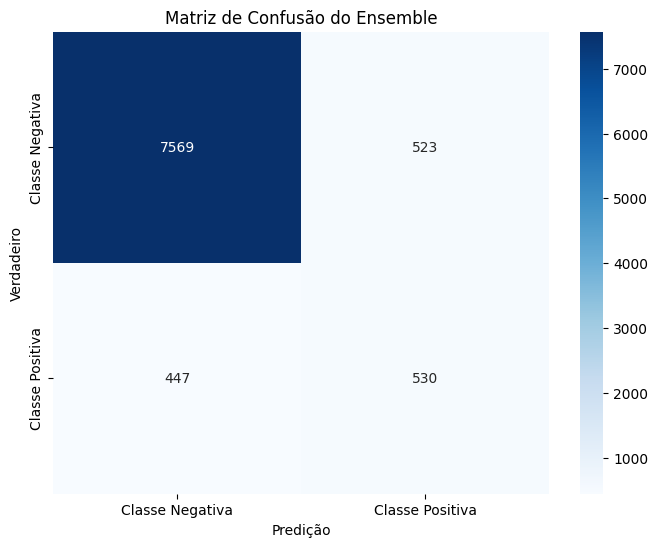

In [ ]:
# Criando os modelos otimizados com os melhores hiperparâmetros
lightgbm_model = LGBMClassifier(
    subsample=0.8, num_leaves=200, n_estimators=500,
    min_child_samples=10, max_depth=20,
    learning_rate=0.05, colsample_bytree=0.8, random_state=42
)

random_forest_model = RandomForestClassifier(
    n_estimators=500, min_samples_split=2, min_samples_leaf=1,
    max_features='log2', max_depth=None, bootstrap=True, random_state=42
)

catboost_model = CatBoostClassifier(
    learning_rate=0.2, l2_leaf_reg=1, iterations=1000,
    depth=8, border_count=32, boosting_type='Plain',
    bagging_temperature=0.5, verbose=0, random_state=42
)

# Criando o ensemble com soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('LightGBM', lightgbm_model),
        ('Random Forest', random_forest_model),
        ('CatBoost', catboost_model)
    ],
    voting='soft'  # Usar soft voting para basear-se nas probabilidades preditivas
)

# Treinando o ensemble
ensemble_model.fit(X_train_selected, y_train_balanced)

# Fazendo predições
y_pred_ensemble = ensemble_model.predict(X_test_selected)

# Avaliar o modelo no conjunto de teste
accuracy = accuracy_score(y_test_filtered, y_pred_ensemble)
print("="*40)
print(f"Acurácia do ensemble no conjunto de teste: {accuracy:.4f}")
print("="*40)

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test_filtered, y_pred_ensemble))
print("="*40)

# Matriz de confusão
print("Matriz de Confusão:")
conf_matrix = confusion_matrix(y_test_filtered, y_pred_ensemble)
print(conf_matrix)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.title("Matriz de Confusão do Ensemble")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

**Comparação de Resultados: Ensembles Intermediário e Final**

**Desempenho Comparativo**

| Métrica                  | Ensemble Intermediário | Ensemble Final |
|--------------------------|------------------------|----------------|
| **Acurácia**             | 0.8569                | 0.8930         |
| **Classe 0 (Negativa)**  |                        |                |
| - Precisão               | 0.96                  | 0.94           |
| - Recall                 | 0.88                  | 0.94           |
| - F1-Score               | 0.92                  | 0.94           |
| **Classe 1 (Positiva)**  |                        |                |
| - Precisão               | 0.40                  | 0.50           |
| - Recall                 | 0.68                  | 0.54           |
| - F1-Score               | 0.51                  | 0.52           |
| **Macro Avg**            |                        |                |
| - Precisão               | 0.68                  | 0.72           |
| - Recall                 | 0.78                  | 0.74           |
| - F1-Score               | 0.71                  | 0.73           |
| **Weighted Avg**         |                        |                |
| - F1-Score               | 0.87                  | 0.89           |


**Análise Comparativa**

**1. Acurácia**
- O ensemble final obteve uma acurácia de **0.8930**, superior à do ensemble intermediário (**0.8569**), indicando maior capacidade de generalização.

**2. Classe Negativa (0)**
- Ambos os ensembles apresentaram excelente desempenho para a Classe 0, mas o ensemble final mostrou:
  - **Maior recall (de 0.88 para 0.94)**, indicando maior proporção de exemplos negativos corretamente classificados.
  - **F1-Score mais alto (de 0.92 para 0.94)**, consolidando sua precisão e recall.

**3. Classe Positiva (1)**
- O ensemble final apresentou melhorias na **precisão (de 0.40 para 0.50)**, o que significa uma redução nos falsos positivos para a Classe 1.
- O recall da Classe 1 diminuiu ligeiramente (**de 0.68 para 0.54**), mas o **F1-Score foi mantido próximo (de 0.51 para 0.52)**, equilibrando melhor os erros.

**4. Matriz de Confusão**
- O ensemble final:
  - Reduziu os falsos positivos na Classe 0 (de 989 para 523).
  - Identificou corretamente 530 exemplos positivos na Classe 1, com uma pequena redução em relação ao intermediário (668).

---

**Conclusão**
O ensemble final demonstrou superioridade ao intermediário em termos de acurácia e robustez. Ele equilibra melhor o desempenho entre as classes, especialmente ao reduzir falsos positivos na Classe 0 e melhorar a precisão na Classe 1. Este resultado destaca a importância da otimização dos modelos base e do uso de estratégias como soft voting no ensemble final.

## **Conclusão**

O desenvolvimento deste MVP teve como objetivo principal prever o comportamento de clientes em relação à assinatura de um produto bancário específico, utilizando técnicas de machine learning e análise de dados. Ao longo do projeto, realizei diversos passos essenciais para garantir um entendimento profundo do problema, organização dos dados e construção de modelos preditivos eficientes.

**Principais Resultados e Insights**
1. **Entendimento do Problema:** Enquadrei a tarefa como um problema de classificação supervisionada, onde o objetivo era prever a probabilidade de um cliente realizar a assinatura com base em atributos demográficos, financeiros e de interação prévia.

2. **Exploração dos Dados:** A análise exploratória revelou importantes correlações entre variáveis e o comportamento do cliente, destacando atributos como duração da última interação e saldo financeiro como determinantes na tomada de decisão.

3. **Pré-processamento de Dados:**
   - Identifiquei e tratei outliers, valores ausentes e variáveis desbalanceadas, garantindo maior qualidade dos dados para os modelos.
   - Apliquei técnicas como normalização e codificação de atributos categóricos, ajustando os dados para o uso em algoritmos de machine learning.  
   - Utilizei técnicas de balanceamento de classes, como o SMOTE, que foram cruciais para lidar com o desbalanceamento da variável-alvo.

4. **Modelagem:**
   - Testei diferentes algoritmos de machine learning, e analisei métricas de avaliação como precisão, recall e F1-score para selecionar o modelo mais adequado.

5. **Avaliação:**
   - O modelo final apresentou um bom desempenho, indicando que a abordagem adotada conseguiu capturar padrões relevantes nos dados, auxiliando na previsão de comportamento.


**Impactos e Próximos Passos**
Os resultados obtidos demonstram o potencial da aplicação de machine learning em problemas de classificação no setor bancário. A solução proposta pode:
- Otimizar estratégias de marketing ao identificar clientes com maior probabilidade de adesão.
- Direcionar recursos para campanhas mais assertivas, maximizando o retorno sobre o investimento.

**Como próximos passos, pretendo:**
- Implementar o modelo em produção para monitoramento de performance em dados reais.
- Expandir a análise para incluir dados mais recentes e novas variáveis que possam aumentar a assertividade.
- Explorar técnicas avançadas de explicabilidade (como SHAP) para tornar o modelo mais interpretável para o time de negócios.